In [415]:
####################################################################
####### FITTING THE FUNCTIONS TO ALE PLOTS #########################
####################################################################

#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
import random                                                        #for test city selection

#for displaying the cities on map
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker                                   #for setting axes ticks to whole numbers

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator                             #to keep whole numbers on the x-axis
from matplotlib.lines import Line2D                                   #for manual legend creation

# for RR model
#import statsmodels.api as sm                                          #stats models to get linear reg p-values
#from statsmodels.tools.eval_measures import rmse                      #calc rmse from stats models
#import itertools                                                      #for calculating possible combinations of variables
#from sklearn.preprocessing import PolynomialFeatures                  #for polynomial regression
#from sklearn.pipeline import make_pipeline                            #pipeline to create polynomial regression
#from sklearn.linear_model import Ridge

#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV                      #for cross validation
from sklearn.feature_selection import RFE                             #for selecting features for the linear reg
from sklearn.model_selection import cross_val_score                   #for cross validation
from sklearn.model_selection import KFold                            
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler                      #for normalising the data
from sklearn.metrics import r2_score                                  #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
    
# for the ALE plots    
from alibi.explainers import ALE, plot_ale
from scipy.special import erf, erfinv, erfc, erfcinv
#for the curve fitting
from scipy.optimize import curve_fit
import math
#Read in the data
#read in the city info table
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'CITY_ADD_2022_09'))
#CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'MEAN_SUHI'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon_final.xlsx', index_col=None)


# REMEMBER TO REMOVE THIS ONCE THIS CITIES ARE READDED
#CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon.CITY_COUNTRY.isin(
#                    ['BULAWAYO_ZIMBABWE', 'RIO_BRANCO_BRAZIL', 'SANHE_CHINA', 'DAYTON_USA'])].reset_index(drop = True)

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)

# Additional variables
# add evi difference variable
all_monthly_data_df['EVI_D'] = all_monthly_data_df['EVI_U'] - all_monthly_data_df['EVI_R'] 

all_monthly_data_df['LOG_AREA'] = np.log10(all_monthly_data_df.Monthly_Area.values.astype(float))
# add sqrt values of climate variables (evi range is -1 to 1)
all_monthly_data_df['sqrt_EF'] = np.sqrt(all_monthly_data_df.EF.values.astype(float))
all_monthly_data_df['sqrt_RH'] = np.sqrt(all_monthly_data_df.RH.values.astype(float))
all_monthly_data_df['sqrt_TP'] = np.sqrt(all_monthly_data_df.TP.values.astype(float))
all_monthly_data_df['sqrt_T2M'] = np.sqrt(all_monthly_data_df.T2M.values.astype(float))
all_monthly_data_df['sqrt_SSR'] = np.sqrt(all_monthly_data_df.SSR.values.astype(float))
# add one to the sqrt (evi variables +1)
all_monthly_data_df['sqrt_EVI_R_p1'] = np.sqrt(all_monthly_data_df.EVI_R.values.astype(float)+1)
all_monthly_data_df['sqrt_EVI_U_p1'] = np.sqrt(all_monthly_data_df.EVI_U.values.astype(float)+1)

all_monthly_data_df['cube_EVI_D'] = pow(all_monthly_data_df.EVI_D.values.astype(float), 3)

all_monthly_data_df['CROPLAND'] = all_monthly_data_df['CROPLAND_RAIN'] + all_monthly_data_df['CROPLAND_IRR']

# elevation diff
all_monthly_data_df['ELEVATION_D'] = all_monthly_data_df['ELEVATION_U'] - all_monthly_data_df['ELEVATION_R']

#add in albedo diff
all_monthly_data_df['WSA_D'] = all_monthly_data_df['WSA_U'] - all_monthly_data_df['WSA_R']
all_monthly_data_df['BSA_D'] = all_monthly_data_df['BSA_U'] - all_monthly_data_df['BSA_R']

# Add in SSR variable with the seasonality removed (SSR - SSR_month_mean)
SSR_seasonal_cycle = all_monthly_data_df[all_monthly_data_df.Overpass == '13:30'].groupby(['CITY_COUNTRY','month']
                                    ).mean(numeric_only=True).reset_index()[['CITY_COUNTRY','month','SSR']]
SSR_seasonal_cycle = SSR_seasonal_cycle.rename(columns={"SSR": "MONTH_MEAN_SSR"})
all_monthly_data_df = pd.merge(all_monthly_data_df, SSR_seasonal_cycle, how = 'left', on = ['CITY_COUNTRY','month'])
all_monthly_data_df['SSR_NO_SEASON'] = all_monthly_data_df['SSR'] - all_monthly_data_df['MONTH_MEAN_SSR']

#define the overpass time 
overpass_time = '13:30'

#decide on the target variable
#target_variable = 'SUHI_PEAK_GSA'
#target_variable = 'SUHI_PEAK_QUANTILE'
target_variable = 'SUHI_MEAN'
#target_variable = 'SUHI_FP'

predictor_variables =['EF','SSR_NO_SEASON','EVI_U','EVI_R','EVI_D', 'ECC', 'LOG_AREA', 
                         'ELEVATION_D','ROUGHNESS_LENGTH_R','WSA_U', 'WSA_R','WSA_D']

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('Overpass')
variables.append('month')
variables.append('year')
variables.append('CITY_COUNTRY')
variables.append('City')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna().reset_index(drop = True)


#create the test train datasets
all_yrs = [2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
                 2020]
odd_yrs = [2003, 2005, 2007, 2009, 2011,  2013,  2015,  2017,  2019]


data_odd_yrs = all_monthly_data_df2[((all_monthly_data_df2['year'].isin(odd_yrs)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
data_even_yrs = all_monthly_data_df2[(~(all_monthly_data_df2['year'].isin(odd_yrs))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

training_data = data_odd_yrs
test_data = data_even_yrs    
    
#split the data into training and test
X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
from sklearn.preprocessing import MinMaxScaler   
scaler = MinMaxScaler()

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only

#load in the model for the ALE plot variables
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'CITY_ADD_2022_09','All_cities_modelling'))
filename = 'RFR_all_data.sav'
rfr_model_cv = pickle.load(open(filename, 'rb'))

In [416]:
rfr_ale = ALE(rfr_model_cv.predict, feature_names = predictor_variables, target_names = ['SUHI_MEAN'])
rfr_exp = rfr_ale.explain(np.array(X_train_norm) )

In [1070]:
# find tanh fits based on ALE plots
# create dataframe to save the fit parameters to
tanh_parameters = pd.DataFrame(columns = ['Feature_Name', 'A', 'w', 'p', 'c'])
tanh_parameters['Feature_Name'] = ['SSR_NO_SEASON','EVI_R','EVI_D','WSA_R','WSA_D']

arctanh_parameters = pd.DataFrame(columns = ['Feature_Name', 'A_arc', 'w_arc', 'p_arc', 'c_arc'])
arctanh_parameters['Feature_Name'] = ['SSR_NO_SEASON','EVI_R','EVI_D','WSA_R','WSA_D']

logit_parameters = pd.DataFrame(columns = ['Feature_Name', 'A', 'b'])
logit_parameters['Feature_Name'] = ['SSR_NO_SEASON','EVI_R','EVI_D','WSA_R','WSA_D']

erfinv_parameters = pd.DataFrame(columns = ['Feature_Name', 'Function','A', 'w', 'p', 'c'])
erfinv_parameters['Feature_Name'] = ['SSR_NO_SEASON','EVI_R','EVI_D','WSA_R','WSA_D']

#['EF','SSR_NO_SEASON','EVI_U','EVI_R','EVI_D', 'ECC', 'LOG_AREA', 
#  'ELEVATION_D','ROUGHNESS_LENGTH_R','WSA_U', 'WSA_R','WSA_D'] # this tells you the order the features have been fed 

SSR_ALE_vals = rfr_exp.data['ale_values'][1]
SSR_feature_vals = rfr_exp.data['feature_values'][1]

EVI_R_ALE_vals = rfr_exp.data['ale_values'][3]
EVI_R_feature_vals = rfr_exp.data['feature_values'][3]

EVI_D_ALE_vals = rfr_exp.data['ale_values'][4]
EVI_D_feature_vals = rfr_exp.data['feature_values'][4]

WSA_R_ALE_vals = rfr_exp.data['ale_values'][10]
WSA_R_feature_vals = rfr_exp.data['feature_values'][10]

WSA_D_ALE_vals = rfr_exp.data['ale_values'][11]
WSA_D_feature_vals = rfr_exp.data['feature_values'][11]

#print out the names of the variables being investigated to make sure they are the right ones
print('Variables Investigated:', rfr_exp.data['feature_names'][1],rfr_exp.data['feature_names'][3],
                          rfr_exp.data['feature_names'][4], rfr_exp.data['feature_names'][10],
                          rfr_exp.data['feature_names'][11])
# function to fit the curves
def tanhfunc(t, A, w, p, c):  return A * np.tanh(w*t + p) + c

def sinhfunc(t, A, w, p, c):  return A * np.sinh(w*t + p) + c

def fit_tanh(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    popt, pcov = curve_fit(tanhfunc, tt, yy, p0=guess, maxfev=5000)
    A, w, p, c = popt

    return {"A": A, "w": w, "p": p, "c": c, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def negAfit_tanh(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = -abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    popt, pcov = curve_fit(tanhfunc, tt, yy, p0=guess, maxfev=5000)
    A, w, p, c = popt
    return {"A": A, "w": w, "p": p, "c": c, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}


def fit_sinh(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    popt, pcov = curve_fit(sinhfunc, tt, yy, p0=guess, maxfev=5000)
    A, w, p, c = popt

    return {"A": A, "w": w, "p": p, "c": c, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def negAfit_sinh(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = -np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    popt, pcov = curve_fit(sinhfunc, tt, yy, p0=guess, maxfev=5000)
    A, w, p, c = popt

    return {"A": A, "w": w, "p": p, "c": c, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}


def arctanhfunc(t, A_arc, w_arc, p_arc, c_arc):  return A_arc * np.arctanh(w_arc*t + p_arc) + c_arc

# ERROR FUNCTIONS 
# A is amplitude, w controls width/ gradient of curve, p is shift along x axis, c is midpoint
def erfunc(t, A_erf, w_erf, p_erf, c_erf): return A_erf*erf(w_erf*t + p_erf) + c_erf

# complementary error function
def cerfunc(t, A_cerf, w_cerf, p_cerf, c_cerf): return A_cerf*erfc(w_cerf*t + p_cerf) + c_cerf
#inverses for error functions
def erfinvfunc(t, A_ierf, w_ierf, p_ierf, c_ierf): return A_ierf*erfinv(w_ierf*t + p_ierf) + c_ierf
def erfcinvfunc(t, A_icerf, w_icerf, p_icerf, c_icerf): return A_icerf*erfcinv(w_icerf*t + p_icerf) + c_icerf

def weightingfunc(ALE_vals, feature_vals, weighting_high, weighting_low, low_thresh, high_thresh):
    weighted_feature_vals = feature_vals.copy()
    weighted_ALE_vals = ALE_vals.copy()
    for i in range(weighting_low):
        weighted_feature_vals = np.concatenate((weighted_feature_vals, feature_vals[feature_vals < low_thresh]))
        weighted_ALE_vals = np.concatenate((weighted_ALE_vals, ALE_vals[feature_vals < low_thresh]))
    
    for i in range(weighting_high):
        weighted_feature_vals = np.concatenate((weighted_feature_vals, feature_vals[feature_vals > high_thresh]))
        weighted_ALE_vals = np.concatenate((weighted_ALE_vals, ALE_vals[feature_vals > high_thresh]))
    
    return weighted_feature_vals, weighted_ALE_vals

def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))

#simple functions to deal with inf values
def simpletanhfunc(t, A, c):  return A * np.tanh(t) + c
def simplearctanhfunc(t, A, c):  return A * np.arctanh(t) + c

# arctanh function which sets the values which are nan as the upper or lower asymptote
def arctanhfunc_asymptote_nans(t, A_arc, w_arc, p_arc, c_arc):  
    # asmptote at (1-p)/w, (-1-p)/w
    asymptote_1 = (1 - p_arc)/w_arc
    asymptote_2 = (-1 - p_arc)/w_arc
    result =  A_arc * np.arctanh(w_arc*t + p_arc) + c_arc
    for i in range(len(t)):
        if np.isnan(result[i]):
            if (t[i] - asymptote_1) < (t[i] - asymptote_2):
                result[i] = asymptote_1
            else:
                result[i] = asymptote_2
    return result

Variables Investigated: SSR_NO_SEASON EVI_R EVI_D WSA_R WSA_D


In [1039]:
arctanh_values = arctanhfunc_asymptote_nans(ALE_vals_norm, A_arc, w_arc, p_arc, c_arc)

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\2331693011.py:140: RuntimeWarning: invalid value encountered in arctanh
  result =  A_arc * np.arctanh(w_arc*t + p_arc) + c_arc


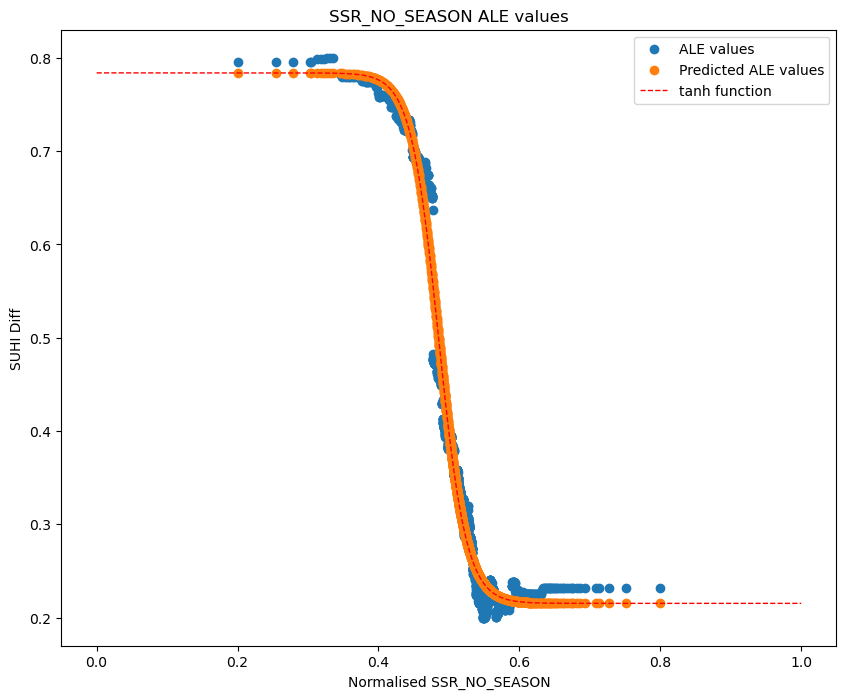

In [1272]:
########################
#### SSR_NO_SEASON  ####
########################
Feature_Name = 'SSR_NO_SEASON'
ALE_vals = SSR_ALE_vals[:,0]
feature_vals = SSR_feature_vals
#ALE_vals_norm = scaler.fit_transform(ALE_vals.reshape(-1, 1)).reshape(1, -1)[0]

logit_scaler = MinMaxScaler(feature_range = (0.2, 0.8))
ALE_vals_norm = logit_scaler.fit_transform(ALE_vals.reshape(-1, 1)).reshape(1, -1)[0]
feature_vals_norm = logit_scaler.fit_transform(feature_vals.reshape(-1, 1)).reshape(1, -1)[0]

#fit the tanh function
res = negAfit_tanh(feature_vals_norm, ALE_vals_norm)
A,w,p,c = res['A'], res['w'], res['p'], res['c']

#generated function values for plotting
x_min = math.floor(feature_vals_norm.min())
x_max = math.ceil(feature_vals_norm.max())

x_vals = np.linspace(x_min, x_max, 1000)
y_vals = tanhfunc(x_vals, A,w,p,c)
ALE_vals_pred = tanhfunc(feature_vals_norm, A,w,p,c)

#tanh_eye_fit = [0.34,-25.28,12.26, 0.5]
#y_vals2 = tanhfunc(x_vals, tanh_eye_fit[0],tanh_eye_fit[1],tanh_eye_fit[2],tanh_eye_fit[3])

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals_norm, ALE_vals_norm, label = 'ALE values')
axes.scatter(feature_vals_norm, ALE_vals_pred, label = 'Predicted ALE values')
axes.plot(x_vals, y_vals, label = 'tanh function', color = 'red', linewidth=1, linestyle ='--')
#axes.plot(x_vals, y_vals2, label = 'Eye Fit tanh function', color = 'purple', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'A'] = A
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'w'] = w
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'p'] = p
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'c'] = c


C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\3159559129.py:103: RuntimeWarning: invalid value encountered in arctanh
  def arctanhfunc(t, A_arc, w_arc, p_arc, c_arc):  return A_arc * np.arctanh(w_arc*t + p_arc) + c_arc
C:\Users\UEA_Laptop\.conda\envs\suhienv_alibi\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


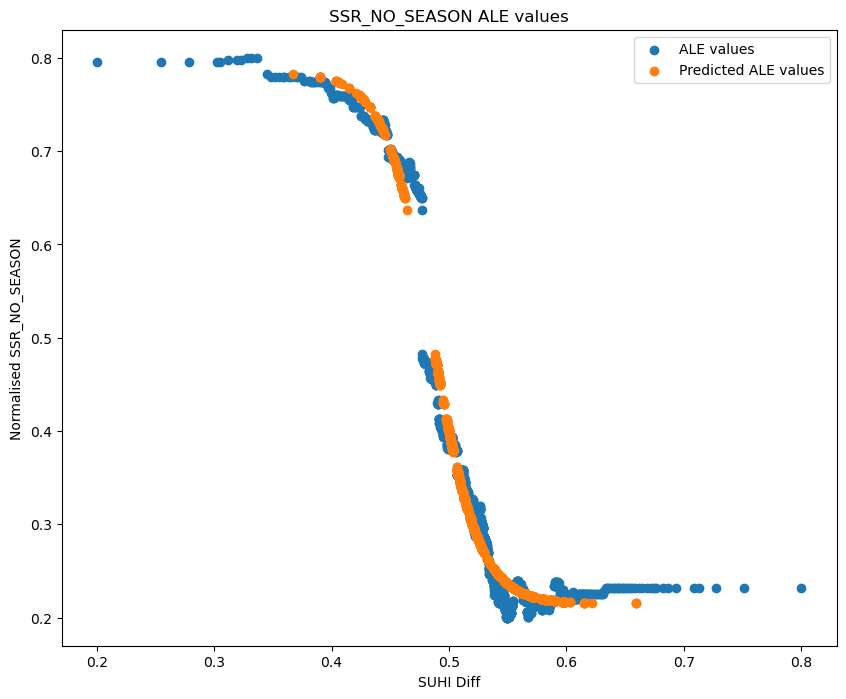

In [1154]:
#### Inverse Functions ####
#guess based on fitted function
A,w,p,c = (tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].A.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].w.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].p.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].c.values[0])

guess = [1/w, 1/A, -c/A, -p/w]

popt, pcov = curve_fit(arctanhfunc, feature_vals_norm, ALE_vals_norm, p0=guess, maxfev=5000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = math.floor(feature_vals_norm.min()) -1
x_max = math.ceil(feature_vals_norm.max()) +1

x_vals = np.linspace(x_min, x_max, 20000)
y_vals = arctanhfunc(x_vals, A,w,p,c)
feature_vals_pred = arctanhfunc(ALE_vals_norm, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals_norm, ALE_vals_norm, label = 'ALE values')
axes.scatter(feature_vals_pred, ALE_vals_norm, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals, label = 'arctanh function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\3159559129.py:103: RuntimeWarning: invalid value encountered in arctanh
  def arctanhfunc(t, A_arc, w_arc, p_arc, c_arc):  return A_arc * np.arctanh(w_arc*t + p_arc) + c_arc


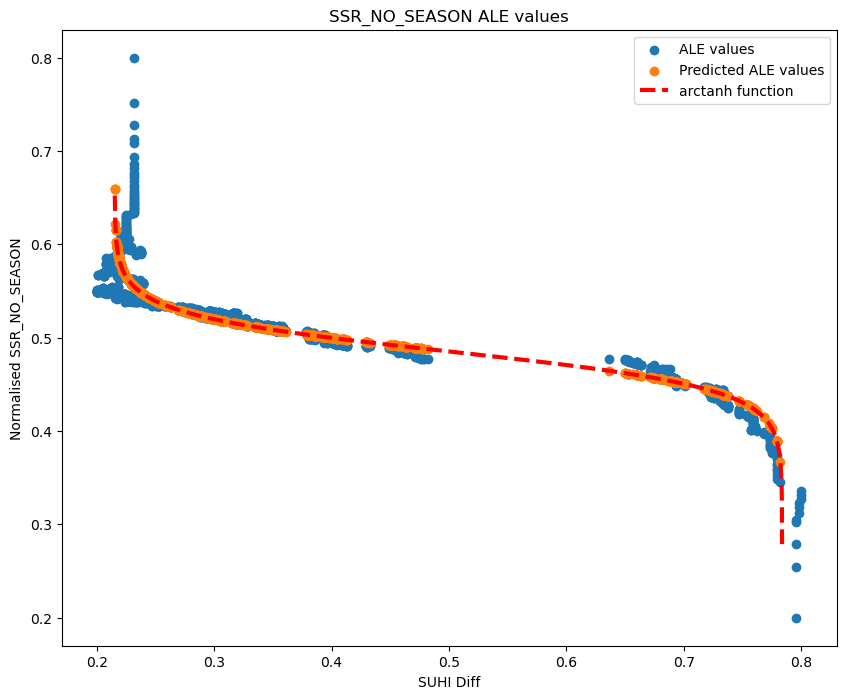

In [1155]:
#### Inverse Functions ####
#guess based on fitted function
A,w,p,c = (tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].A.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].w.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].p.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].c.values[0])

guess = [1/w, 1/A, -c/A, -p/w]

popt, pcov = curve_fit(arctanhfunc, ALE_vals_norm, feature_vals_norm, p0=guess, maxfev=5000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = math.floor(ALE_vals_norm.min()) -1
x_max = math.ceil(ALE_vals_norm.max()) +1


fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals_norm, feature_vals_norm, label = 'ALE values')
axes.scatter(ALE_vals_norm, feature_vals_pred, label = 'Predicted ALE values')
#axes.scatter(ALE_vals_norm, feature_vals_pred2, label = 'Predicted ALE values 2')
axes.plot(x_vals, y_vals, label = 'arctanh function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'A_arc'] = A
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'w_arc'] = w
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'p_arc'] = p
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'c_arc'] = c

[Text(0.5, 1.0, 'SSR_NO_SEASON ALE values'),
 Text(0.5, 0, 'Normalised SSR_NO_SEASON'),
 Text(0, 0.5, 'Arctanh ALE values')]

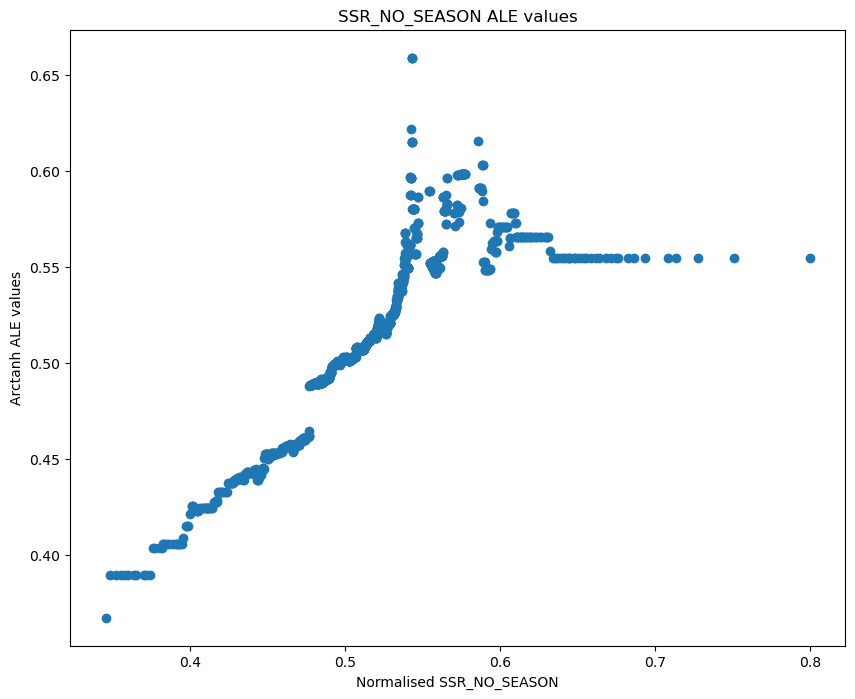

In [1156]:
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals_norm, feature_vals_pred, label = 'ALE values')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'Arctanh ALE values'.format(Feature_Name))

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\3159559129.py:103: RuntimeWarning: invalid value encountered in arctanh
  def arctanhfunc(t, A_arc, w_arc, p_arc, c_arc):  return A_arc * np.arctanh(w_arc*t + p_arc) + c_arc


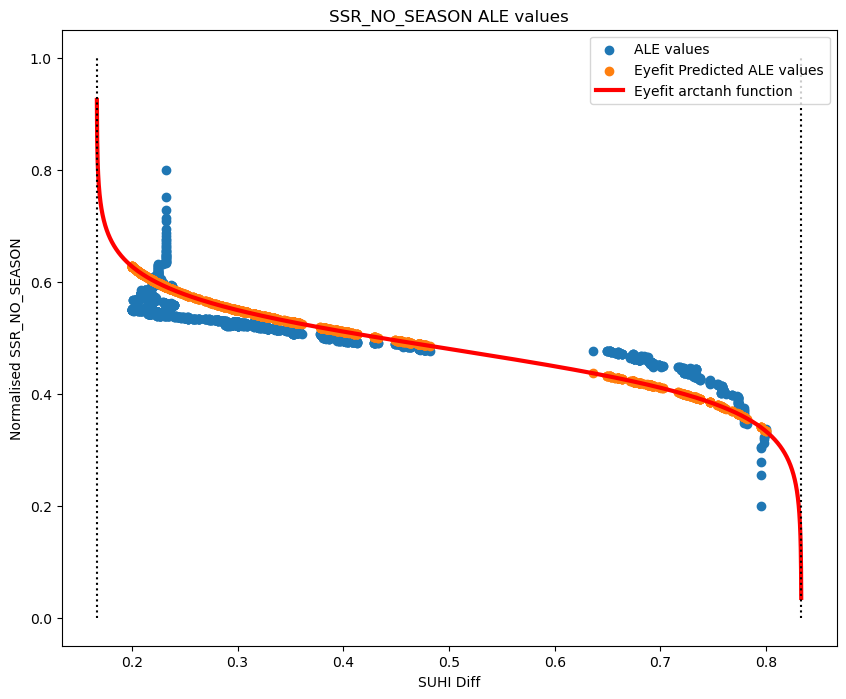

In [1157]:
#generated function values for plotting
x_min = math.floor(ALE_vals_norm.min()) -1
x_max = math.ceil(ALE_vals_norm.max()) +1

x_vals = np.linspace(x_min, x_max, 20000)
# A,w,p,c
eye_fit = [-0.1, 3,-1.5, 0.48]
feature_vals_pred = arctanhfunc(ALE_vals_norm, eye_fit[0], eye_fit[1], eye_fit[2], eye_fit[3])
y_vals = arctanhfunc(x_vals, eye_fit[0], eye_fit[1], eye_fit[2], eye_fit[3])

# asmptote at (1-p)/w, (-1-p)/w
asymptote1 = (1 - eye_fit[2])/eye_fit[1]
asymptote2 = (-1 - eye_fit[2])/eye_fit[1]


fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals_norm, feature_vals_norm, label = 'ALE values')
axes.scatter(ALE_vals_norm, feature_vals_pred, label = 'Eyefit Predicted ALE values')
axes.plot(x_vals, y_vals, label = 'Eyefit arctanh function', color = 'red', linewidth=3)
axes.vlines(asymptote1, 0, 1, color = 'black', linestyle = 'dotted')
axes.vlines(asymptote2, 0, 1, color = 'black', linestyle = 'dotted')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()


In [729]:
def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))

In [1228]:
a,b,c,d,e,f

(-0.5804810978970125,
 3.2231715488722723,
 2.0,
 0.0001,
 -0.2326743934307283,
 -0.14496374017040065)

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\690004782.py:1: RuntimeWarning: invalid value encountered in log
  def func(x, a,b,c,d,e,f): return (a*np.log(b*x/(1-x))) + 0*x**2+ d*x + e + 2*x**(1/2)
C:\Users\UEA_Laptop\.conda\envs\suhienv_alibi\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


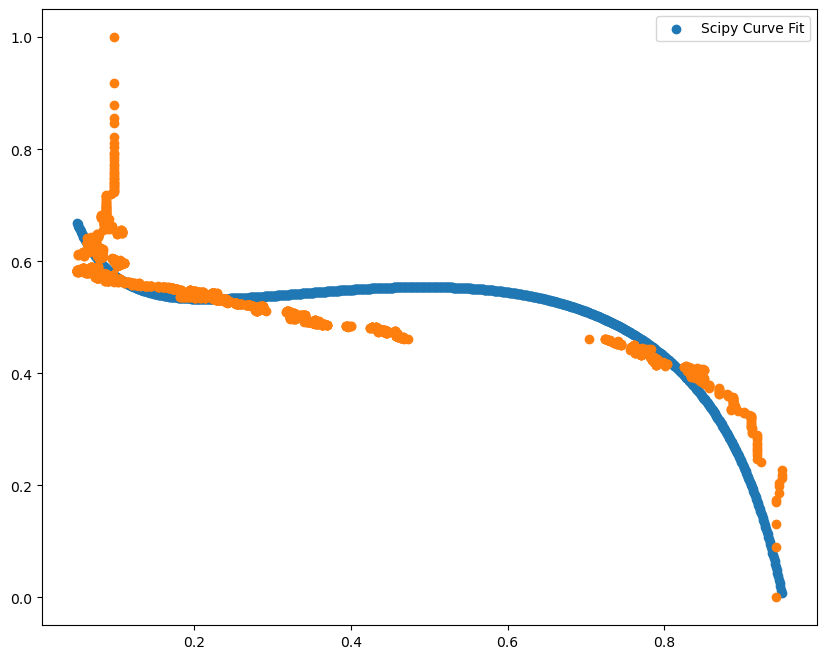

In [1236]:
def func(x, a,b,c,d,e,f): return (a*np.log(b*x/(1-x))) + 0*x**2+ d*x + e + 2*x**(1/2)

logit_scaler = MinMaxScaler(feature_range = (0.05, 0.95))
ALE_vals_logit_scaled = logit_scaler.fit_transform(ALE_vals.reshape(-1, 1)).reshape(1, -1)[0]

guess = [-0.9, 1,2,1/10000,-5, 1]
popt, pcov = curve_fit(func, ALE_vals_logit_scaled, feature_vals, p0=guess, maxfev=50000)
a,b,c,d,e,f = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]

x_min = ALE_vals_logit_scaled.min()
x_max = ALE_vals_logit_scaled.max()

fig, axes = plt.subplots(1,1, figsize = (10, 8))

x_vals = np.linspace(x_min,x_max, 1000)
y_vals = func(x_vals, a,b,c,d,e,f)

#a,b,c,d,e = -0.118, 4.47e-05, -0.113, 0.437, -0.89
#a,b,c,d,e = -0.118, 4.47e-05, -0.113, 1, -0.89
y_vals2 = func(x_vals, a,b,c,d,e,f)
# plot the features and function
axes.scatter(x_vals, y_vals, label = 'Scipy Curve Fit')
#axes.scatter(x_vals, y_vals2, label = 'Eye Fit')
axes.scatter(ALE_vals_logit_scaled, feature_vals)
axes.legend()
#y_vals = arctanhfunc(x_vals, A,w,p,c)
#feature_vals_pred = func(ALE_vals_logit_scaled, a,b,c,d,e )
#axes.scatter(ALE_vals_logit_scaled, feature_vals_pred)

#A,w,p,c = tanh_eye_fit[0],tanh_eye_fit[1],tanh_eye_fit[2],tanh_eye_fit[3] 
#A,w,p,c = [1/w, 1/A, -c/A, -p/w]
#feature_vals_pred2 = sinhfunc(ALE_vals_norm, A,w,p,c)

In [1288]:
a,b,c,d

(-36.47479645967226, 1.0, 1.0, 0.5540863127208735)

C:\Users\UEA_Laptop\.conda\envs\suhienv_alibi\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


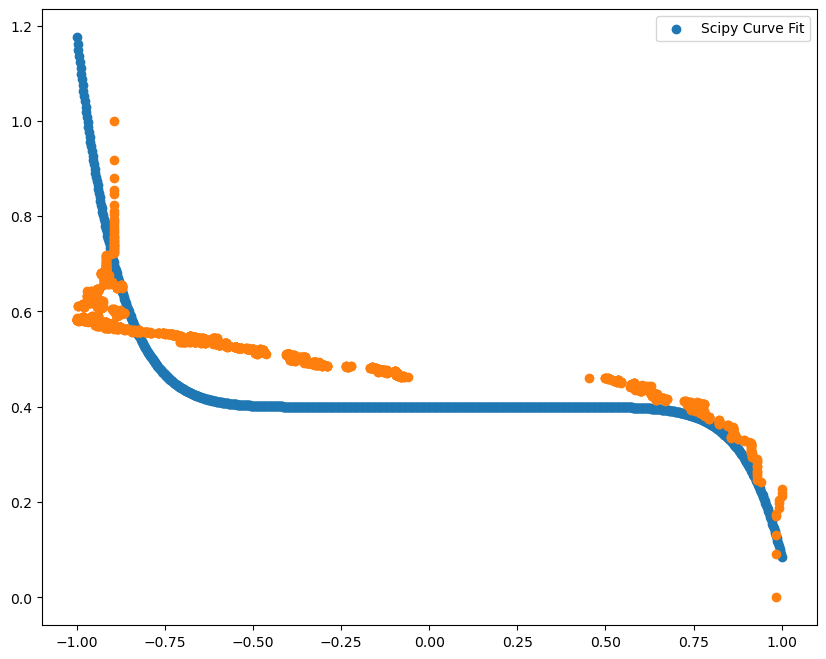

In [1328]:
def func(x, a,b,c,d): return a*(x - b)**9 + c

# use weighted values
#feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 40, 
#                                   weighting_low =40  ,low_thresh = -0.06, high_thresh =0.18 )

cube_scaler = MinMaxScaler(feature_range = (-1, 1))
ALE_vals_scaled = cube_scaler.fit_transform(ALE_vals.reshape(-1, 1)).reshape(1, -1)[0]

guess = [-0.5,0.05,0.4,0]
popt, pcov = curve_fit(func, ALE_vals, feature_vals, p0=guess, maxfev=50000)
a,b,c,d= popt[0], popt[1], popt[2],popt[3] 

x_min = ALE_vals_scaled.min()
x_max = ALE_vals_scaled.max()

fig, axes = plt.subplots(1,1, figsize = (10, 8))

x_vals = np.linspace(x_min,x_max, 1000)
#y_vals = func(x_vals, a,b,c,d)
y_vals = func(x_vals, -0.5,0.05,0.4,0)

a2,b2,c2,d2 = -0.1, 1.51, 0.5, 0.5
#a,b,c,d,e = -0.118, 4.47e-05, -0.113, 1, -0.89
#y_vals2 = func(x_vals, a2,b2,c2,d2)
# plot the features and function
axes.scatter(x_vals, y_vals, label = 'Scipy Curve Fit')
#axes.scatter(x_vals, y_vals2, label = 'Eye Fit cube')
axes.scatter(ALE_vals_scaled, feature_vals)
axes.legend()
#y_vals = arctanhfunc(x_vals, A,w,p,c)
#feature_vals_pred = func(ALE_vals_logit_scaled, a,b,c,d,e )
#axes.scatter(ALE_vals_logit_scaled, feature_vals_pred)


In [1321]:
a,b,c,d

(-2.223926142780401e-05, 2.321549022442974, 0.2783511338768516, 0.0)

In [1249]:
feature_vals

array([0.        , 0.09057761, 0.13096701, ..., 0.87930184, 0.9182546 ,
       1.        ])

In [1165]:
x_vals[np.isnan(y_vals)]

array([], dtype=float64)

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\3159559129.py:128: RuntimeWarning: divide by zero encountered in divide
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))
C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\3159559129.py:128: RuntimeWarning: divide by zero encountered in log
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))


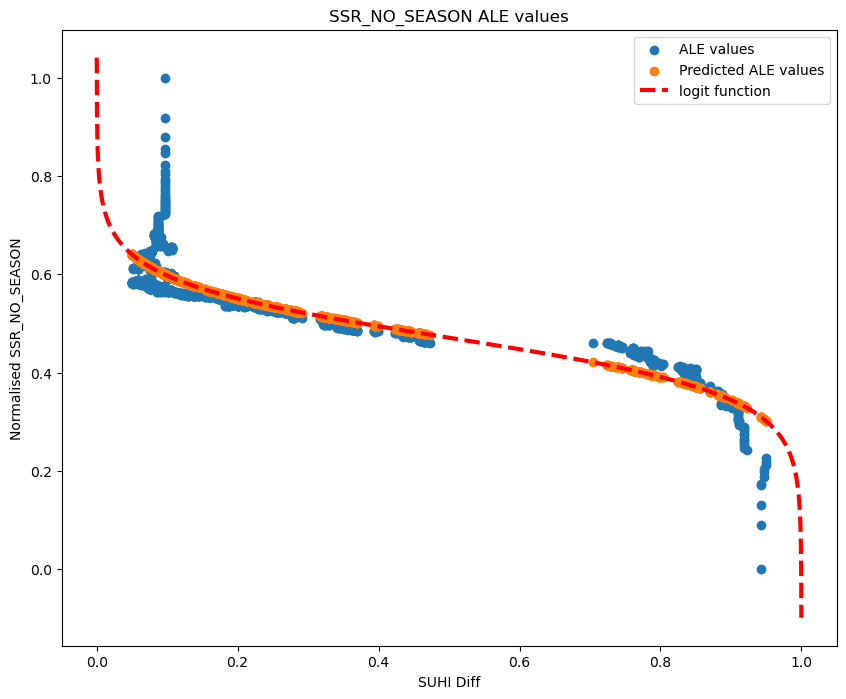

In [1091]:
#### Inverse Functions: LOGIT ####
# use weighted values
#feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 50, 
#                                  weighting_low = 50, low_thresh = 0.2, high_thresh =0.55 )

logit_scaler = MinMaxScaler(feature_range = (0.05, 0.95))
ALE_vals_logit_scaled = logit_scaler.fit_transform(ALE_vals.reshape(-1, 1)).reshape(1, -1)[0]

guess = [np.float64(0.035), np.float64(0.5)]

popt, pcov = curve_fit(complogitfunc, ALE_vals_logit_scaled, feature_vals, p0=guess, maxfev=10000)
A,b = popt[0], popt[1]

#generated function values for plotting
x_min = 0
x_max = 1
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = complogitfunc(x_vals, A,b)
feature_vals_pred = complogitfunc(ALE_vals_logit_scaled, A,b)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals_logit_scaled, feature_vals, label = 'ALE values')
axes.scatter(ALE_vals_logit_scaled, feature_vals_pred, label = 'Predicted ALE values', )
axes.plot(x_vals, y_vals, label = 'logit function', color = 'red', linewidth=3, linestyle = '--')

#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'A'] = A
logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'b'] = b


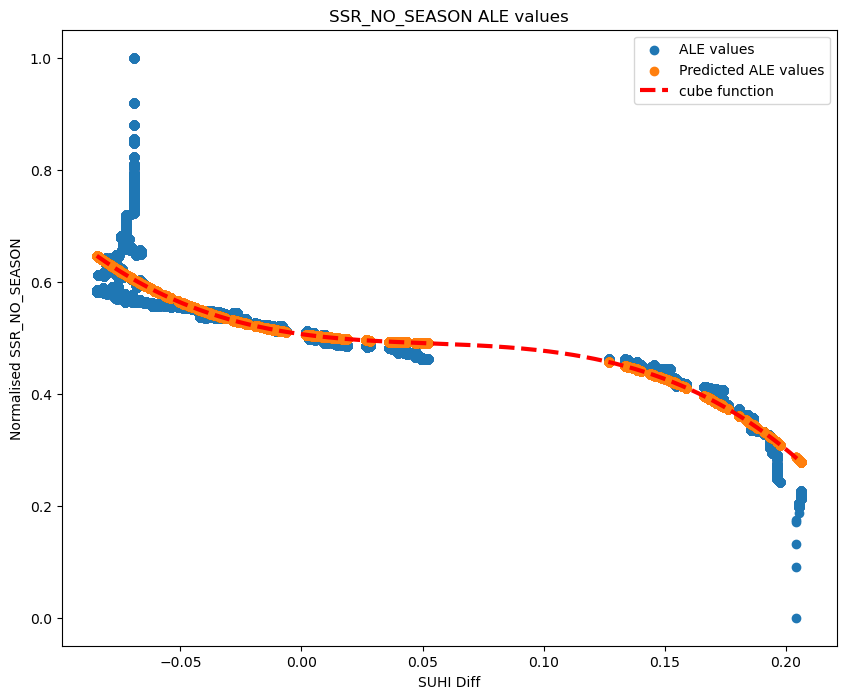

In [1118]:
#### Inverse Functions: LOGIT ####
# use weighted values
Feature_Name = 'SSR_NO_SEASON'
ALE_vals = SSR_ALE_vals[:,0]
feature_vals = SSR_feature_vals

feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 100, 
                                  weighting_low = 100, low_thresh = -0.05, high_thresh =0.19 )

guess = [0.1,0,0,0]
def cubefunc(t, A,b,c,d): return A*t**3 + b*t**2 + c*t + d
popt, pcov = curve_fit(cubefunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,b,c,d= popt[0], popt[1],popt[2],popt[3]

#generated function values for plotting
x_min =ALE_vals.min()
x_max = ALE_vals.max()
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = cubefunc(x_vals, A,b,c,d)
feature_vals_pred = cubefunc(ALE_vals, A,b,c,d)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'ALE values')
axes.scatter(ALE_vals, feature_vals_pred, label = 'Predicted ALE values', )
axes.plot(x_vals, y_vals, label = 'cube function', color = 'red', linewidth=3, linestyle = '--')

#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()


[Text(0.5, 1.0, 'SSR_NO_SEASON ALE values'),
 Text(0.5, 0, 'Normalised SSR_NO_SEASON'),
 Text(0, 0.5, 'Cube ALE values')]

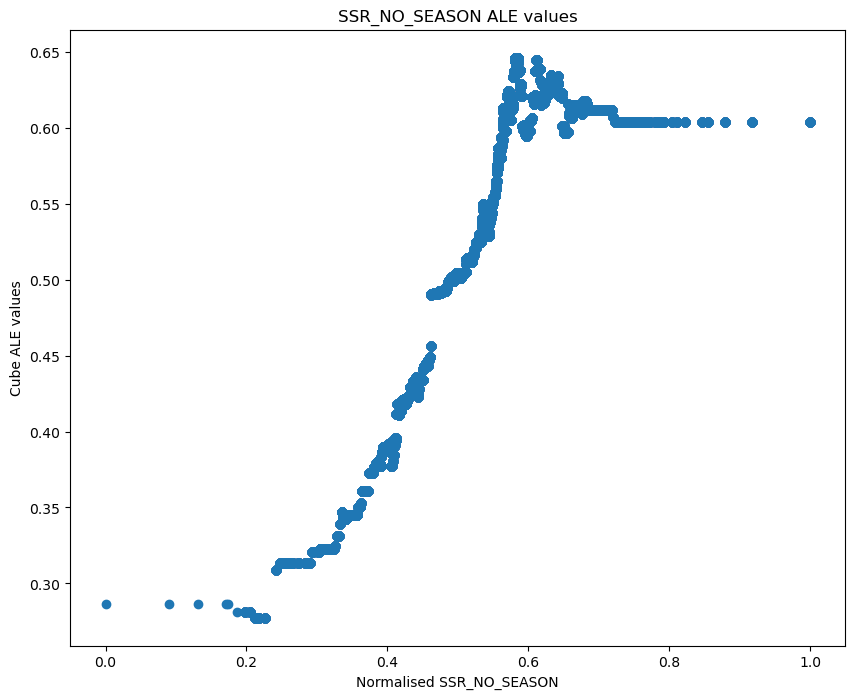

In [1119]:
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, feature_vals_pred, label = 'ALE values')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'Cube ALE values'.format(Feature_Name))

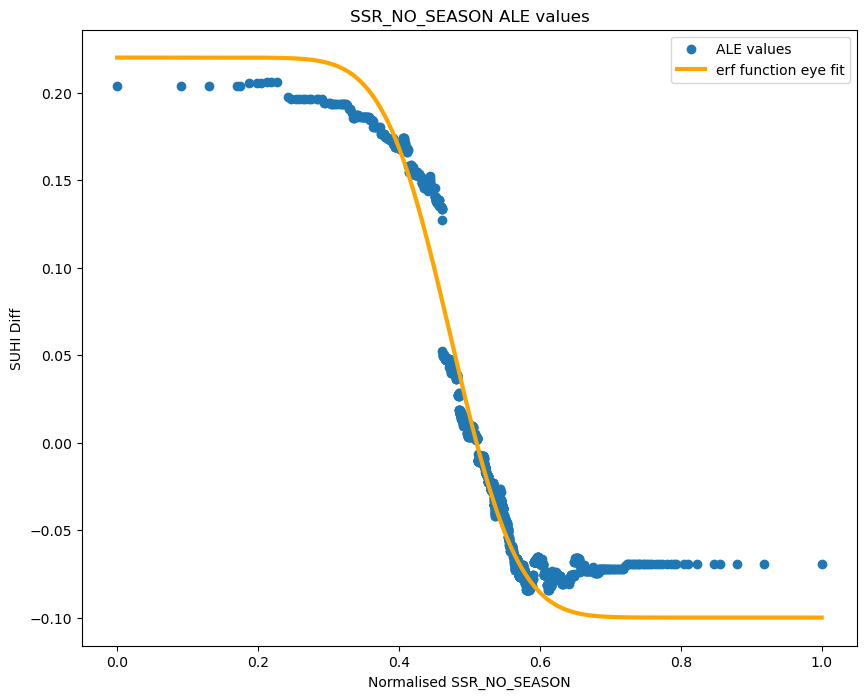

In [941]:
### erf function ###
Feature_Name = 'SSR_NO_SEASON'
ALE_vals = SSR_ALE_vals[:,0]
feature_vals = SSR_feature_vals

# use weighted values
#feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 1, 
#                                   weighting_low = 1, low_thresh = -1, high_thresh =2 )

#fit the erf function
#guess = [0.5,4,-1.8,0.4]
#popt, pcov = curve_fit(cerfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
#A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = feature_vals.min()
x_max = feature_vals.max()

x_vals = np.linspace(x_min, x_max, 1000)
y_vals = cerfunc(x_vals, A,w,p,c)

# A is amplitude, w controls width/ gradient of curve, p is shift along x axis, c is midpoint
erf_eye = [0.16,9.5,-4.5,-0.1]
y_vals2 = cerfunc(x_vals,erf_eye[0],erf_eye[1],erf_eye[2],erf_eye[3])


fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
#axes.plot(x_vals, y_vals, label = 'erf function scipy fit', color = 'red', linewidth=3, linestyle = '--')
axes.plot(x_vals, y_vals2, label = 'erf function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()


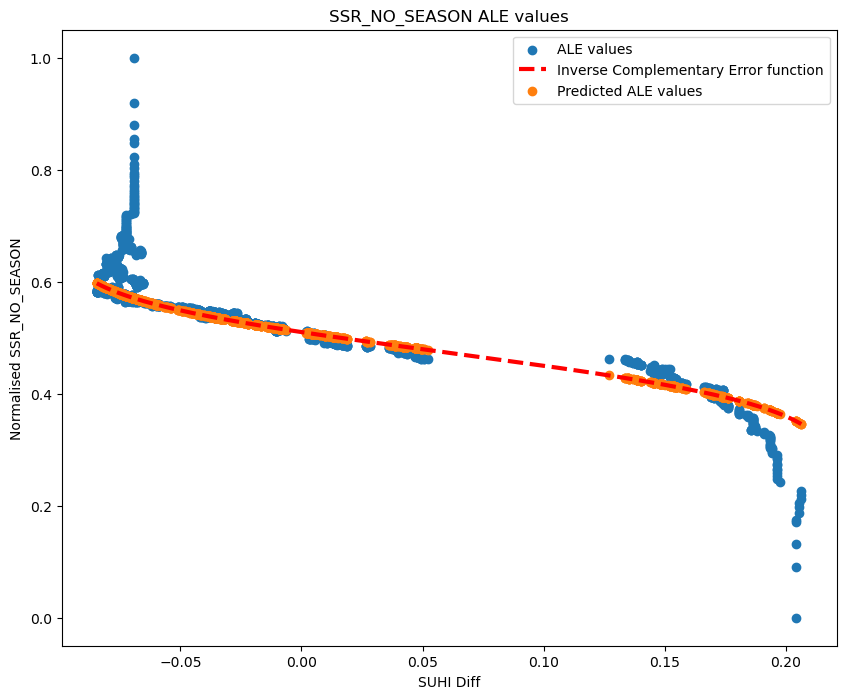

In [942]:
## inverse erf function

A,w,p,c = erf_eye[0],erf_eye[1],erf_eye[2],erf_eye[3]
guess = [1/w, 1/A, -c/A, -p/w]
cerf_eye_inv = [1/w, 1/A, -c/A, -p/w]
#popt, pcov = curve_fit(erfinvfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
#A,w,p,c = popt[0], popt[1], popt[2], popt[3]

A,w,p,c = cerf_eye_inv[0],cerf_eye_inv[1],cerf_eye_inv[2],cerf_eye_inv[3]

#generated function values for plotting
x_min = ALE_vals.min()
x_max = ALE_vals.max()
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = erfcinvfunc(x_vals, A,w,p,c)
feature_vals_pred = erfcinvfunc(ALE_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'Inverse Complementary Error function', color = 'red', linewidth=3, linestyle = '--')
axes.scatter(ALE_vals, feature_vals_pred, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'A'] = A
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'w'] = w
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'p'] = p
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'c'] = c
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'Function'] = 'cerfinv'

In [943]:
ALE_vals[np.isnan(feature_vals_pred)]

array([], dtype=float64)

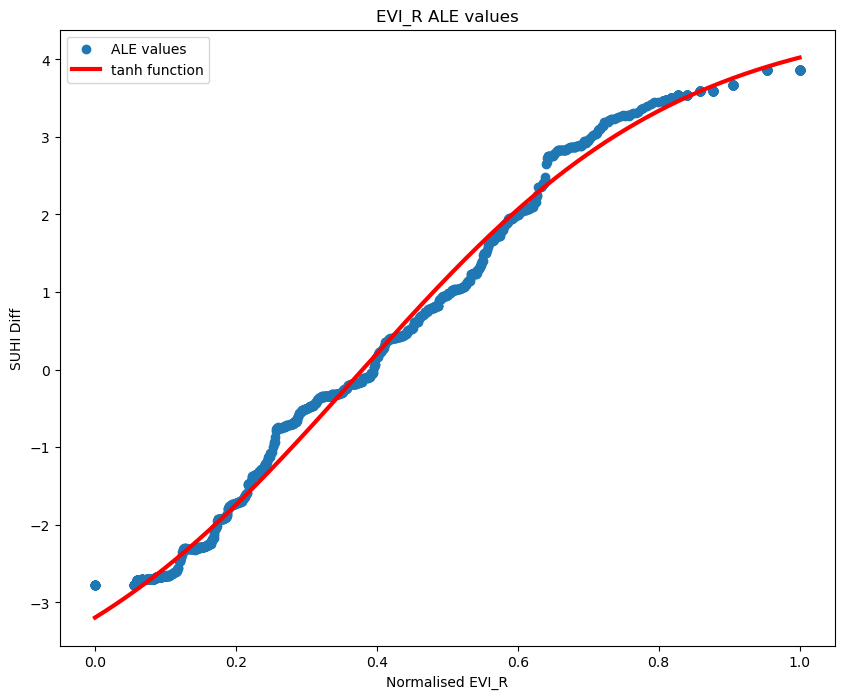

In [994]:
###############
#### EVI_R ####
###############
Feature_Name = 'EVI_R'
ALE_vals = EVI_R_ALE_vals[:,0]
feature_vals = EVI_R_feature_vals

# use weighted values
feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 50, 
                                  weighting_low = 20, low_thresh = 0.1, high_thresh =0.8 )

#fit the tanh function
res = fit_tanh(feature_vals, ALE_vals)
A,w,p,c = res['A'], res['w'], res['p'], res['c']

#generated function values for plotting
x_min = math.floor(feature_vals.min())
x_max = math.ceil(feature_vals.max())

x_min = feature_vals.min()
x_max = feature_vals.max()

#x_min = -2.2
#x_max = 3.5

x_vals = np.linspace(x_min, x_max, 1000)
y_vals = tanhfunc(x_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'tanh function', color = 'red', linewidth=3)
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'A'] = A
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'w'] = w
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'p'] = p
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'c'] = c


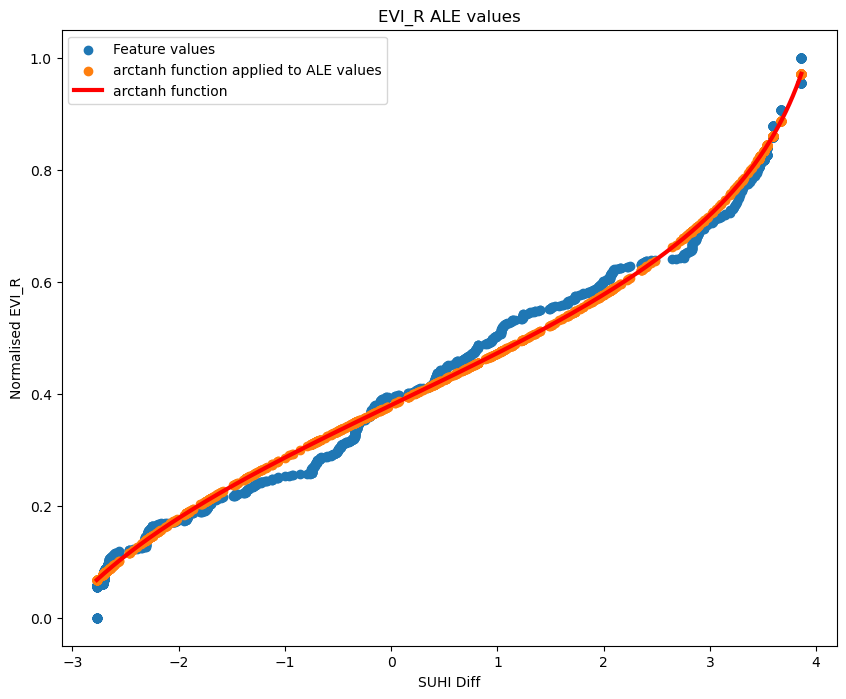

In [995]:
#### Inverse Functions ####
#guess based on fitted function

A,w,p,c = (tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].A.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].w.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].p.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].c.values[0])

guess = [1/w, 1/A, -c/A, -p/w]

popt, pcov = curve_fit(arctanhfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = ALE_vals.min()
x_max = ALE_vals.max()

x_vals = np.linspace(x_min, x_max, 2000)
y_vals = arctanhfunc(x_vals, A,w,p,c)
feature_vals_pred = arctanhfunc(ALE_vals, A,w,p,c)
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'Feature values')
axes.scatter(ALE_vals, feature_vals_pred, label = 'arctanh function applied to ALE values')
axes.plot(x_vals, y_vals, label = 'arctanh function', color = 'red', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'A_arc'] = A
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'w_arc'] = w
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'p_arc'] = p
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'c_arc'] = c

[Text(0.5, 1.0, 'EVI_R ALE values'),
 Text(0.5, 0, 'Normalised EVI_R'),
 Text(0, 0.5, 'Arctanh ALE values')]

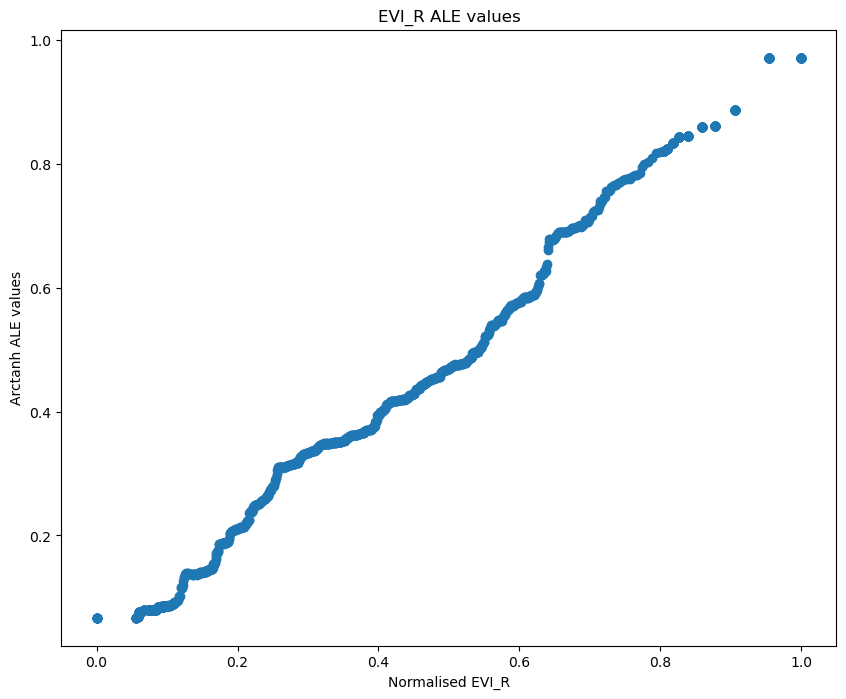

In [996]:
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, feature_vals_pred, label = 'ALE values')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'Arctanh ALE values'.format(Feature_Name))

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:129: RuntimeWarning: divide by zero encountered in divide
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))
C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:129: RuntimeWarning: divide by zero encountered in log
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))


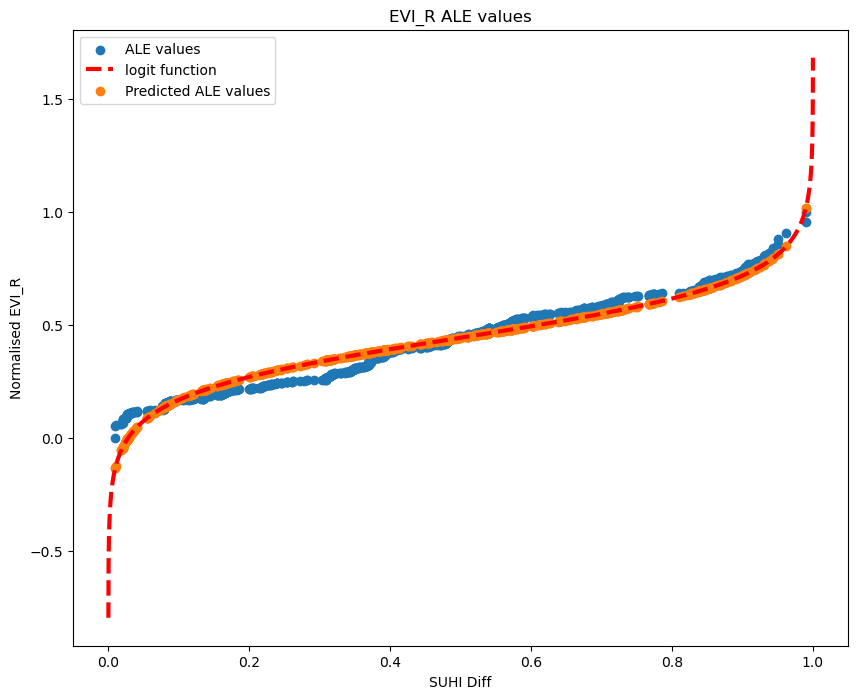

In [989]:
#### Inverse Functions: LOGIT ####

logit_scaler = MinMaxScaler(feature_range = (0.01, 0.99))
ALE_vals_logit_scaled = logit_scaler.fit_transform(ALE_vals.reshape(-1, 1)).reshape(1, -1)[0]

guess = [np.float64(0.035), np.float64(0.5)]

popt, pcov = curve_fit(complogitfunc, ALE_vals_logit_scaled, feature_vals, p0=guess, maxfev=10000)
A,b = popt[0], popt[1]

#generated function values for plotting
x_min = 0
x_max = 1
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = complogitfunc(x_vals, A,b)
feature_vals_pred = complogitfunc(ALE_vals_logit_scaled, A,b)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals_logit_scaled, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'logit function', color = 'red', linewidth=3, linestyle = '--')
axes.scatter(ALE_vals_logit_scaled, feature_vals_pred, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'A'] = A
logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'b'] = b

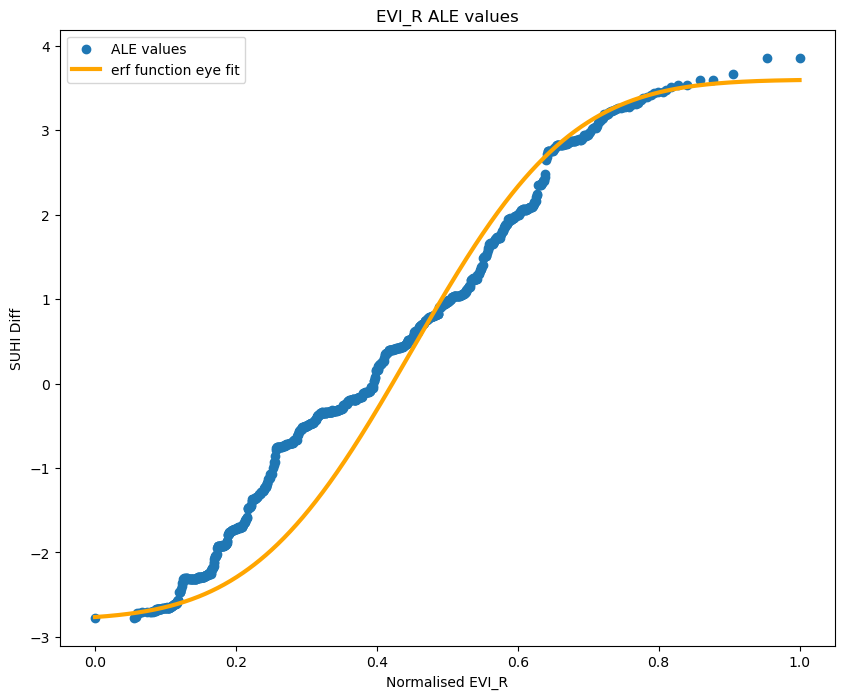

In [982]:
### erf function ###
Feature_Name = 'EVI_R'
ALE_vals = EVI_R_ALE_vals[:,0]
feature_vals = EVI_R_feature_vals

# use weighted values
feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 1, 
                                   weighting_low = 1, low_thresh = -1, high_thresh =2 )

#fit the erf function
guess = [3.2,4,-1.8,0.4]
popt, pcov = curve_fit(erfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = feature_vals.min()
x_max = feature_vals.max()

x_vals = np.linspace(x_min, x_max, 1000)
y_vals = erfunc(x_vals, A,w,p,c)

# A is amplitude, w controls width/ gradient of curve, p is shift along x axis, c is midpoint
erf_eye = [3.2,4,-1.8,0.4]
y_vals2 = erfunc(x_vals,erf_eye[0],erf_eye[1],erf_eye[2],erf_eye[3])


fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
#axes.plot(x_vals, y_vals, label = 'erf function scipy fit', color = 'red', linewidth=3, linestyle = '--')
axes.plot(x_vals, y_vals2, label = 'erf function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()


C:\Users\UEA_Laptop\.conda\envs\suhienv_alibi\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


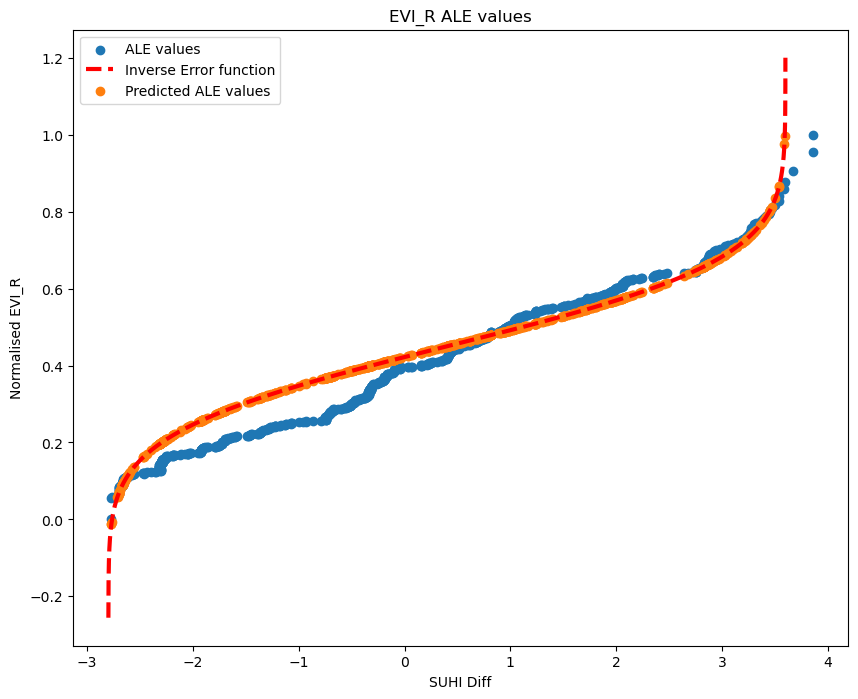

In [983]:
## inverse erf function

A,w,p,c = 3.2,4,-1.8,0.4
guess = [1/w, 1/A, -c/A, -p/w]
popt, pcov = curve_fit(erfinvfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = -3
x_max = 4
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = erfinvfunc(x_vals, A,w,p,c)
feature_vals_pred = erfinvfunc(ALE_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'Inverse Error function', color = 'red', linewidth=3, linestyle = '--')
axes.scatter(ALE_vals, feature_vals_pred, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'A'] = A
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'w'] = w
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'p'] = p
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'c'] = c
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'Function'] = 'erfinv'


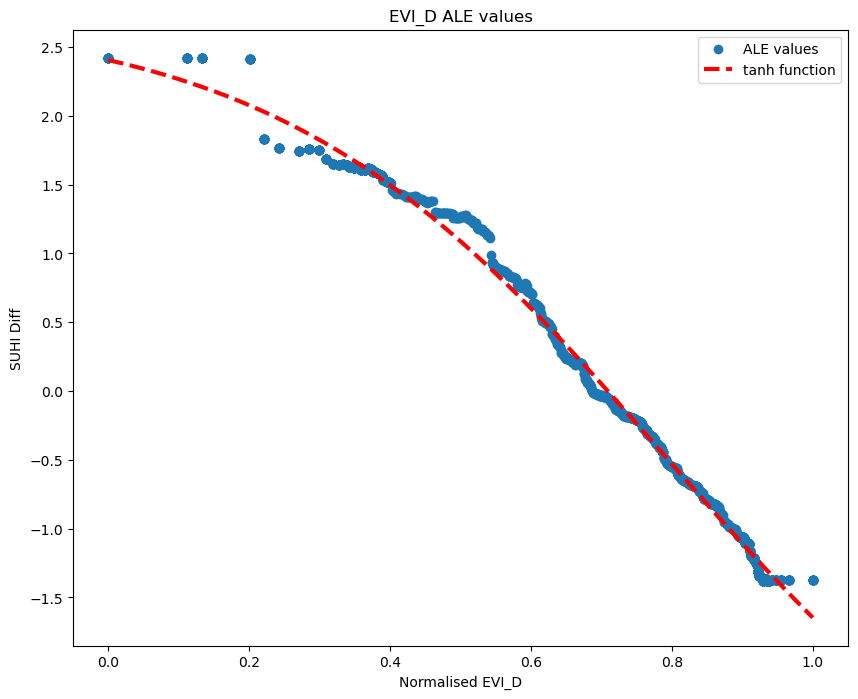

In [997]:
###############
#### EVI_D ####
###############
Feature_Name = 'EVI_D'
ALE_vals = EVI_D_ALE_vals[:,0]
feature_vals = EVI_D_feature_vals

# use weighted values
feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 20, 
                                   weighting_low = 20, low_thresh = 0.4, high_thresh =0.9 )

#fit the tanh function
res = negAfit_tanh(feature_vals, ALE_vals)
A,w,p,c = res['A'], res['w'], res['p'], res['c']

#generated function values for plotting
x_min = math.floor(feature_vals.min())
x_max = math.ceil(feature_vals.max())

x_min = feature_vals.min()
x_max = feature_vals.max()

#x_min = -2.2
#x_max = 3.5

x_vals = np.linspace(x_min, x_max, 1000)
y_vals = tanhfunc(x_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'tanh function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'A'] = A
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'w'] = w
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'p'] = p
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'c'] = c

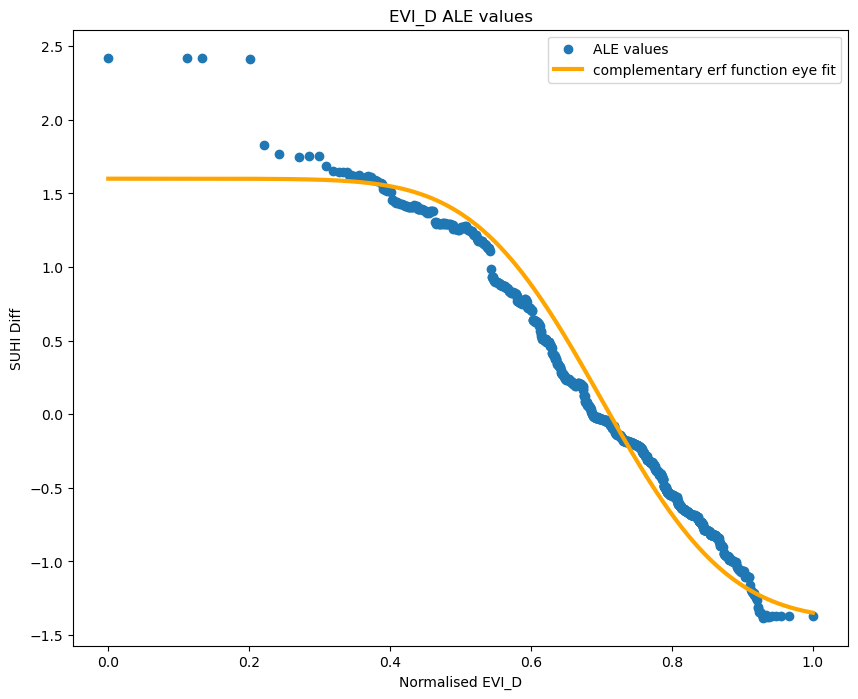

In [912]:
### erf function ###
Feature_Name = 'EVI_D'
ALE_vals = EVI_D_ALE_vals[:,0]
feature_vals = EVI_D_feature_vals

# complementary error function
def erfcfunc(t, A_erfc, w_erfc, p_erfc, c_erfc): return A_erfc*erfc(w_erfc*t + p_erfc) + c_erfc

# use weighted values
feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 25, 
                                   weighting_low = 25, low_thresh = -1, high_thresh =2 )

#fit the erf function
guess = [1.5,5,-3.5,-1.4]
popt, pcov = curve_fit(erfcfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = math.floor(feature_vals.min())
x_max = math.ceil(feature_vals.max())

x_min = feature_vals.min()
x_max = feature_vals.max()

#x_min = -2.2
#x_max = 3.5

x_vals = np.linspace(x_min, x_max, 1000)
y_vals = erfcfunc(x_vals, A,w,p,c)
# A is amplitude, w controls width/ gradient of curve, p is shift along x axis, c is midpoint
erfc_eye = [1.5,5,-3.5,-1.4]
y_vals2 = erfcfunc(x_vals,erfc_eye[0],erfc_eye[1],erfc_eye[2],erfc_eye[3])

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
#axes.plot(x_vals, y_vals, label = 'complementary erf function scipy fit', color = 'red', linewidth=3, linestyle = '--')
axes.plot(x_vals, y_vals2, label = 'complementary erf function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()

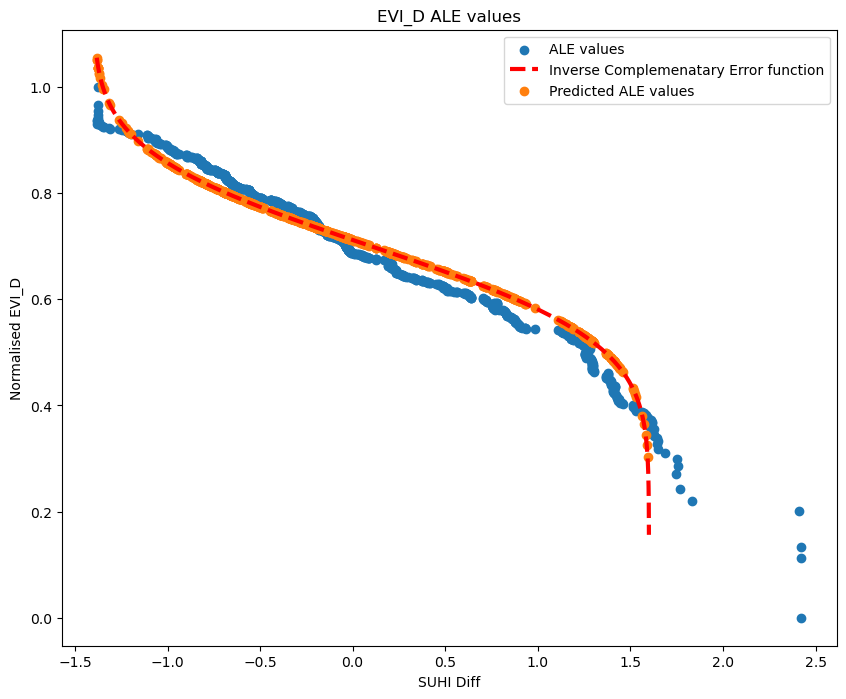

In [913]:
## inverse erf function

A,w,p,c = 1.5,5,-3.5,-1.4
guess = [1/w, 1/A, -c/A, -p/w]
popt, pcov = curve_fit(erfcinvfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = ALE_vals.min()
x_max = ALE_vals.max()
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = erfcinvfunc(x_vals, A,w,p,c)
feature_vals_pred = erfcinvfunc(ALE_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'Inverse Complemenatary Error function', color = 'red', linewidth=3, linestyle = '--')
axes.scatter(ALE_vals, feature_vals_pred, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'A'] = A
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'w'] = w
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'p'] = p
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'c'] = c
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'Function'] = 'cerfinv'

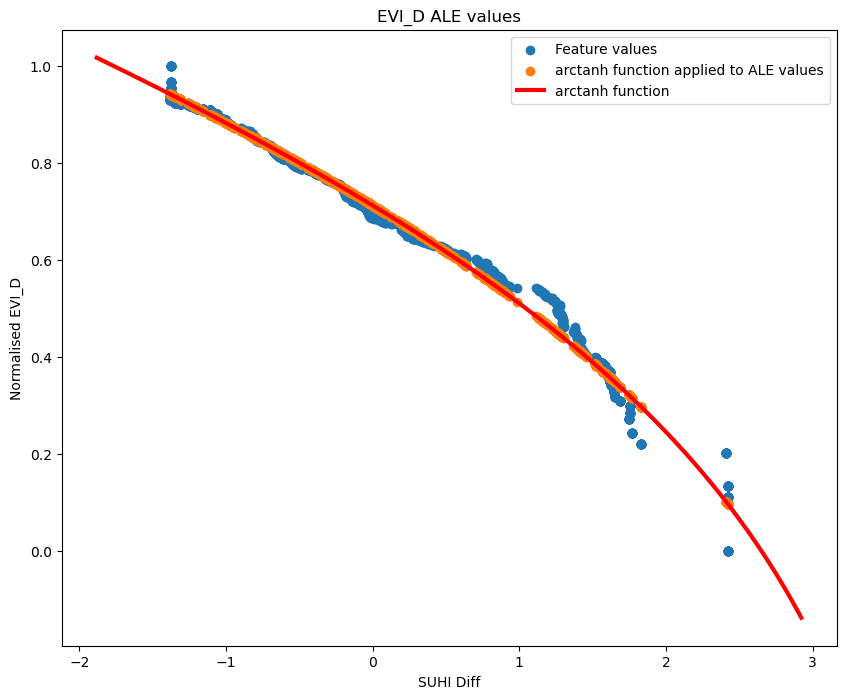

In [999]:
#### Inverse Functions ####
#guess based on fitted function

A,w,p,c = (tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].A.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].w.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].p.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].c.values[0])

guess = [1/w, 1/A, -c/A, -p/w]

popt, pcov = curve_fit(arctanhfunc, ALE_vals, feature_vals, p0=guess, maxfev=5000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = ALE_vals.min() - 0.5
x_max = ALE_vals.max() +0.5

x_vals = np.linspace(x_min, x_max, 2000)
y_vals = arctanhfunc(x_vals, A,w,p,c)
feature_vals_pred = arctanhfunc(ALE_vals, A,w,p,c)
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'Feature values')
axes.scatter(ALE_vals, feature_vals_pred, label = 'arctanh function applied to ALE values')
axes.plot(x_vals, y_vals, label = 'arctanh function', color = 'red', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()
# add the fit parameters to the dataframe

arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'A_arc'] = A
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'w_arc'] = w
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'p_arc'] = p
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'c_arc'] = c

[Text(0.5, 1.0, 'EVI_D ALE values'),
 Text(0.5, 0, 'Normalised EVI_D'),
 Text(0, 0.5, 'Arctanh ALE values')]

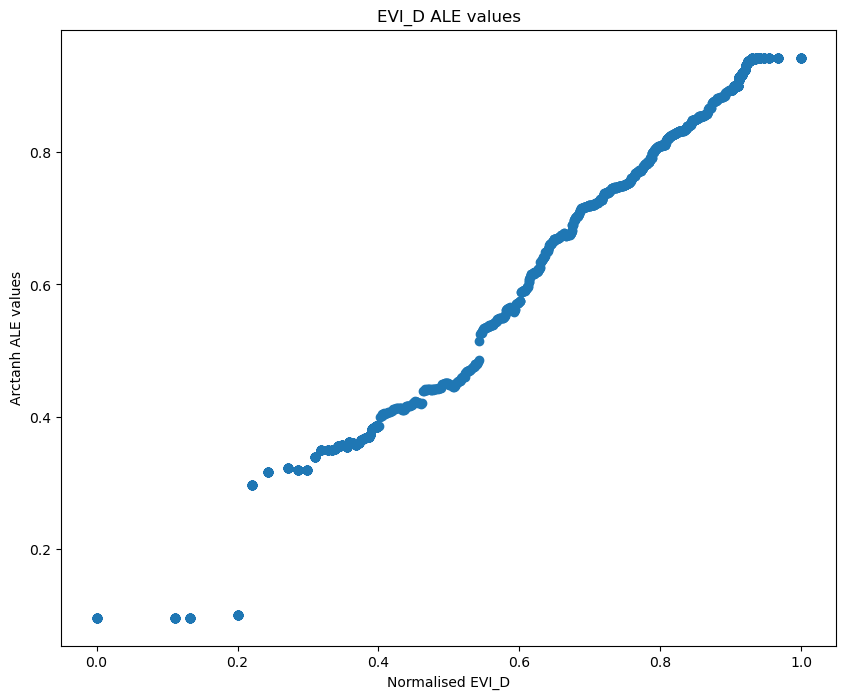

In [1000]:
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, feature_vals_pred, label = 'ALE values')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'Arctanh ALE values'.format(Feature_Name))

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:129: RuntimeWarning: divide by zero encountered in divide
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))
C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:129: RuntimeWarning: divide by zero encountered in log
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))


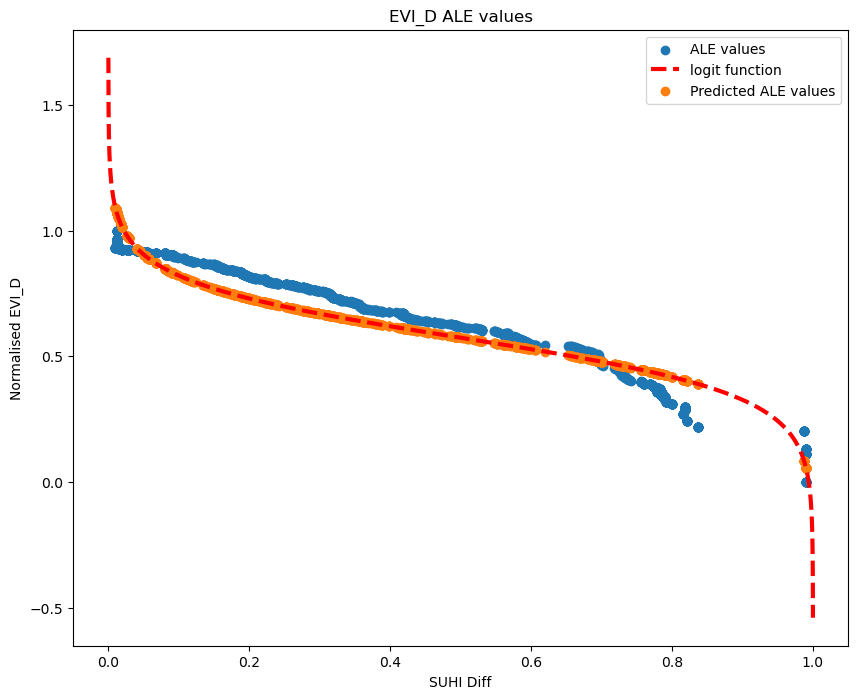

In [998]:
#### Inverse Functions: LOGIT ####

logit_scaler = MinMaxScaler(feature_range = (0.01, 0.99))
ALE_vals_logit_scaled = logit_scaler.fit_transform(ALE_vals.reshape(-1, 1)).reshape(1, -1)[0]

guess = [np.float64(0.035), np.float64(0.5)]

popt, pcov = curve_fit(complogitfunc, ALE_vals_logit_scaled, feature_vals, p0=guess, maxfev=10000)
A,b = popt[0], popt[1]

#generated function values for plotting
x_min = 0
x_max = 1
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = complogitfunc(x_vals, A,b)
feature_vals_pred = complogitfunc(ALE_vals_logit_scaled, A,b)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals_logit_scaled, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'logit function', color = 'red', linewidth=3, linestyle = '--')
axes.scatter(ALE_vals_logit_scaled, feature_vals_pred, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'A'] = A
logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'b'] = b

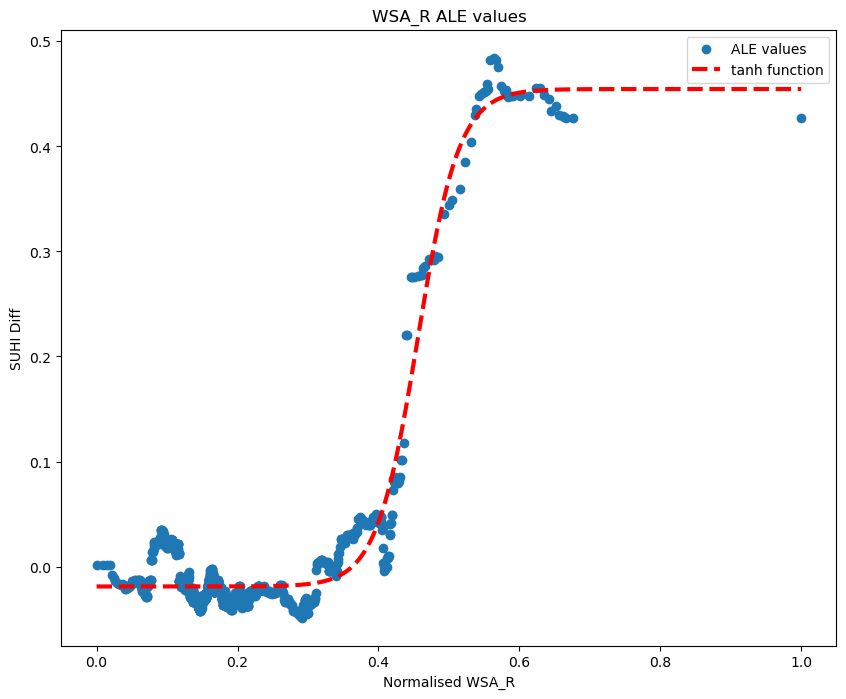

In [1001]:
###############
#### WSA_R ####
###############
Feature_Name = 'WSA_R'
ALE_vals = WSA_R_ALE_vals[:,0]
feature_vals = WSA_R_feature_vals

# use weighted values
#feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 8, 
#                                   weighting_low = 8, low_thresh = -1.5, high_thresh =2.5 )

#fit the tanh function
res = fit_tanh(feature_vals, ALE_vals)
A,w,p,c = res['A'], res['w'], res['p'], res['c']

#generated function values for plotting
x_min = math.floor(feature_vals.min())
x_max = math.ceil(feature_vals.max())

x_min = feature_vals.min()
x_max = feature_vals.max()

x_vals = np.linspace(x_min, x_max, 1000)
y_vals = tanhfunc(x_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'tanh function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'A'] = A
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'w'] = w
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'p'] = p
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'c'] = c

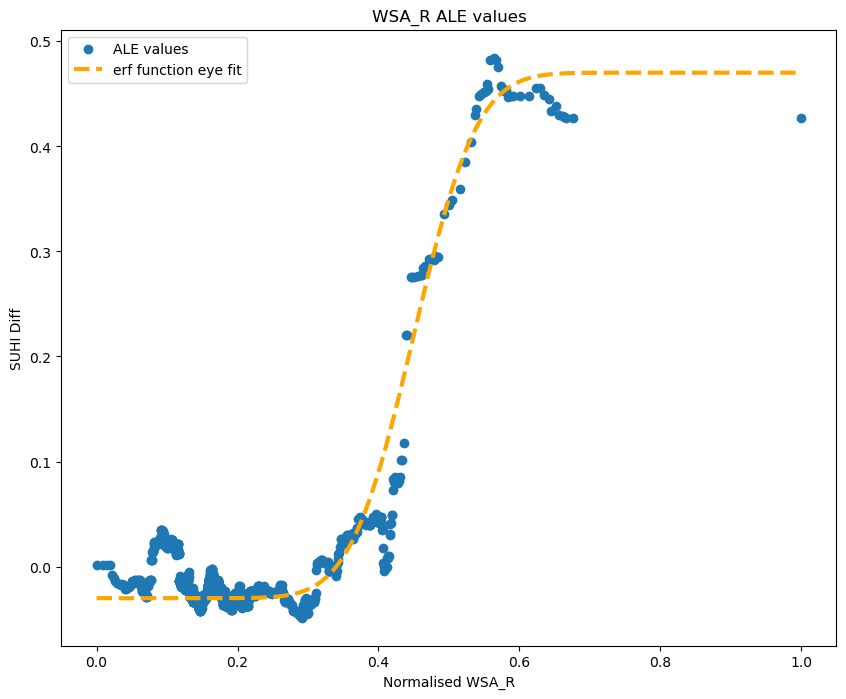

In [917]:
### erf function ###
Feature_Name = 'WSA_R'
ALE_vals = WSA_R_ALE_vals[:,0]
feature_vals = WSA_R_feature_vals

# use weighted values
feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 25, 
                                   weighting_low = 25, low_thresh = -1, high_thresh =2 )

# max and mins for plotting and guesses
x_min = feature_vals.min()
x_max = feature_vals.max()

y_min = ALE_vals.min()
y_max = ALE_vals.max()

#fit the erf function
guess = [(abs(y_max) + abs(y_min))/2,  1.5,-3.4 ,(y_max +y_min)/2]
popt, pcov = curve_fit(erfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]
# A is amplitude, w controls width/ gradient of curve, p is shift along x axis, c is midpoint

#generated function values for plotting
x_vals = np.linspace(x_min, x_max, 1000)
y_vals = erfunc(x_vals, A,w,p,c)
erf_eye = [0.25,10,-4.5,0.22]
y_vals2 = erfunc(x_vals,erf_eye[0],erf_eye[1],erf_eye[2],erf_eye[3])

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
#axes.plot(x_vals, y_vals, label = 'erf function', color = 'red', linewidth=3)
axes.plot(x_vals, y_vals2, label = 'erf function eye fit', color = 'orange', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()


C:\Users\UEA_Laptop\.conda\envs\suhienv_alibi\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


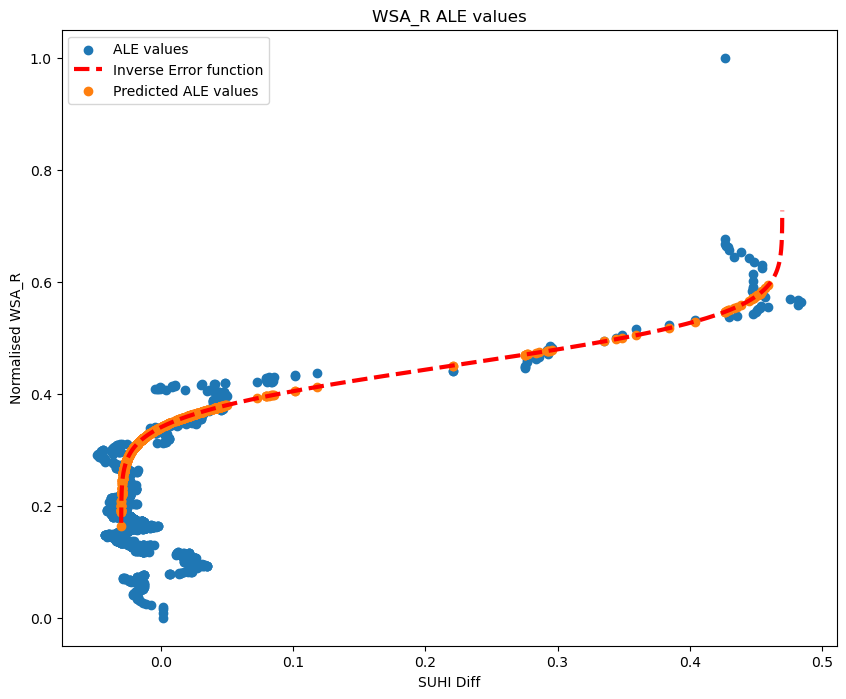

In [918]:
## inverse erf function

A,w,p,c = 0.25,10,-4.5,0.22
guess = [1/w, 1/A, -c/A, -p/w]
popt, pcov = curve_fit(erfinvfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = ALE_vals.min()
x_max = ALE_vals.max()
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = erfinvfunc(x_vals, A,w,p,c)
feature_vals_pred = erfinvfunc(ALE_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'Inverse Error function', color = 'red', linewidth=3, linestyle = '--')
axes.scatter(ALE_vals, feature_vals_pred, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'A'] = A
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'w'] = w
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'p'] = p
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'c'] = c
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'Function'] = 'erfinv'

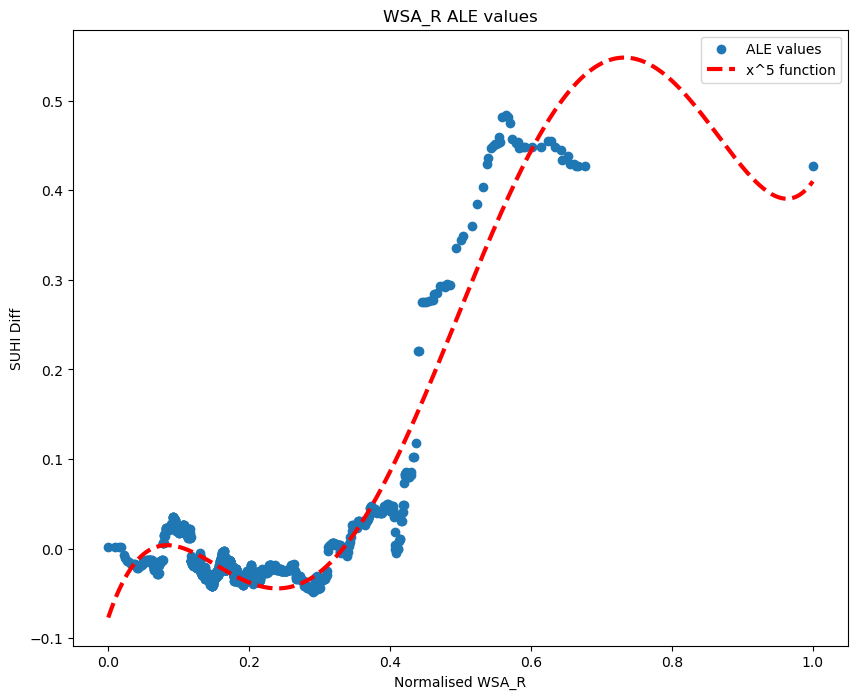

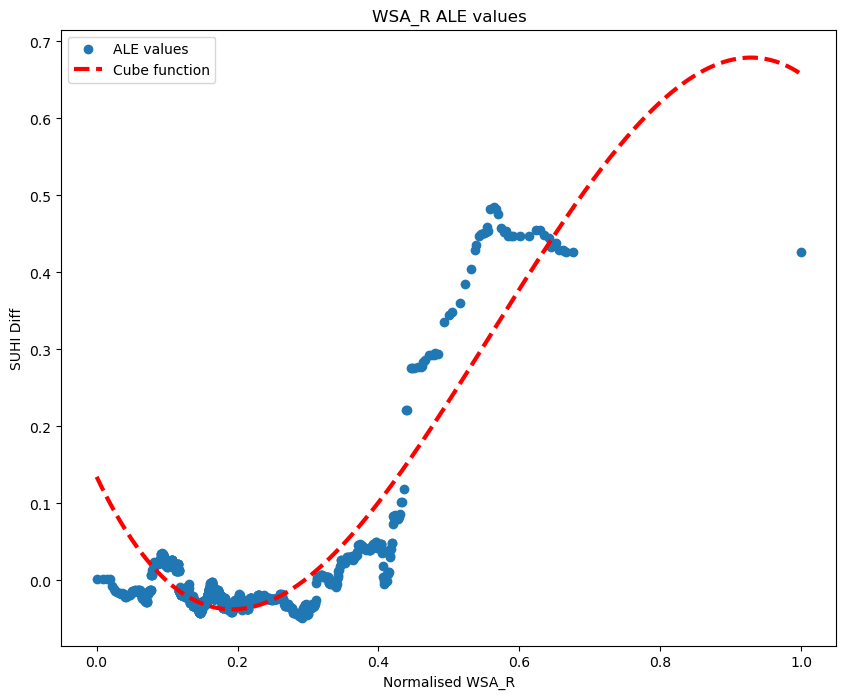

In [1004]:
### x^3, x^5 function ###
Feature_Name = 'WSA_R'
ALE_vals = WSA_R_ALE_vals[:,0]
feature_vals = WSA_R_feature_vals

# use weighted values
#feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 25, 
#                                   weighting_low = 25, low_thresh = -1, high_thresh =2 )

#generated function values for plotting

x_min = feature_vals.min()
x_max = feature_vals.max()

poly_params = np.polyfit(feature_vals, ALE_vals, deg= 5)
x_vals = np.linspace(x_min, x_max, 1000)
y_vals = np.polyval(poly_params, x_vals)
           
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'x^5 function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()

poly_params = np.polyfit(feature_vals, ALE_vals, deg= 3)
x_vals = np.linspace(x_min, x_max, 1000)
y_vals = np.polyval(poly_params, x_vals)
           
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'Cube function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()


C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:104: RuntimeWarning: invalid value encountered in arctanh
  def arctanhfunc(t, A_arc, w_arc, p_arc, c_arc):  return A_arc * np.arctanh(w_arc*t + p_arc) + c_arc
C:\Users\UEA_Laptop\.conda\envs\suhienv_alibi\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


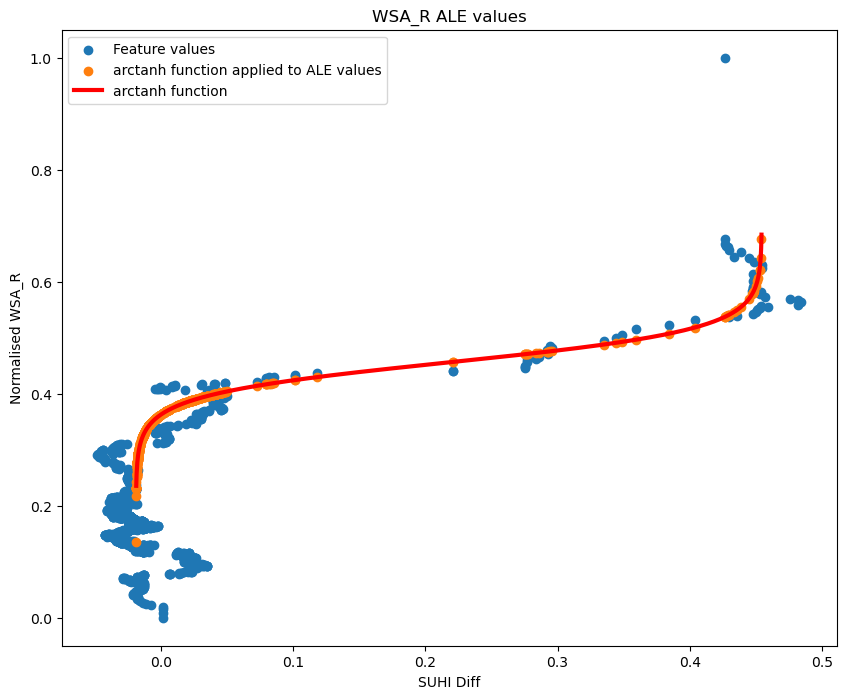

In [1002]:
#### Inverse Functions ####
#guess based on fitted function

A,w,p,c = (tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].A.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].w.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].p.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].c.values[0])

guess = [1/w, 1/A, -c/A, -p/w]

popt, pcov = curve_fit(arctanhfunc, ALE_vals, feature_vals, p0=guess, maxfev=5000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = ALE_vals.min()
x_max = ALE_vals.max()

x_vals = np.linspace(x_min, x_max, 2000)
y_vals = arctanhfunc(x_vals, A,w,p,c)
feature_vals_pred = arctanhfunc(ALE_vals, A,w,p,c)
fig, axes = plt.subplots(1,1, figsize = (10, 8))


# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'Feature values')
axes.scatter(ALE_vals, feature_vals_pred, label = 'arctanh function applied to ALE values')
axes.plot(x_vals, y_vals, label = 'arctanh function', color = 'red', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'A_arc'] = A
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'w_arc'] = w
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'p_arc'] = p
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'c_arc'] = c

[Text(0.5, 1.0, 'WSA_R ALE values'),
 Text(0.5, 0, 'Normalised WSA_R'),
 Text(0, 0.5, 'Arctanh ALE values')]

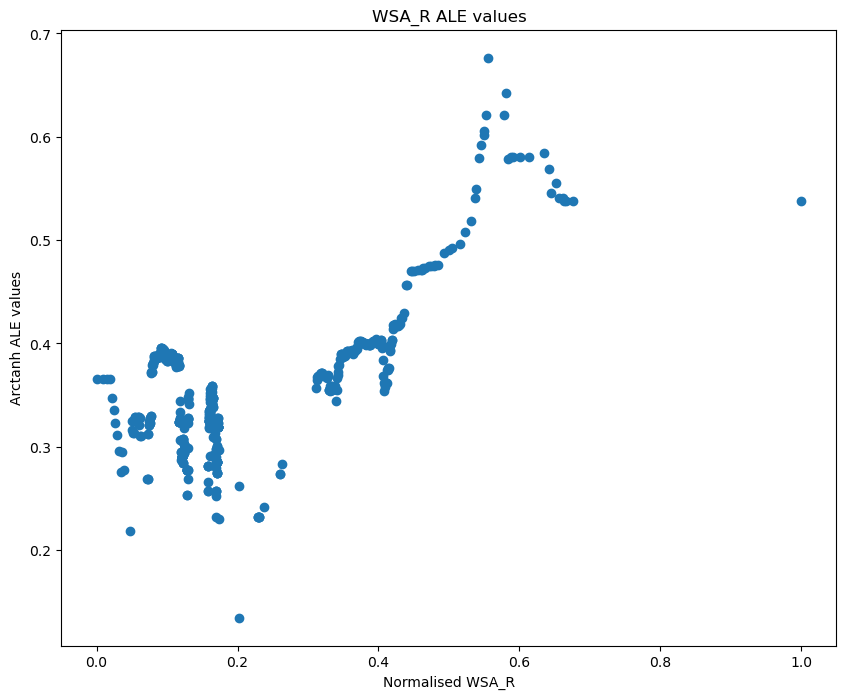

In [1003]:
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, feature_vals_pred, label = 'ALE values')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'Arctanh ALE values'.format(Feature_Name))

In [921]:
erf_eye

[0.25, 10, -4.5, 0.22]

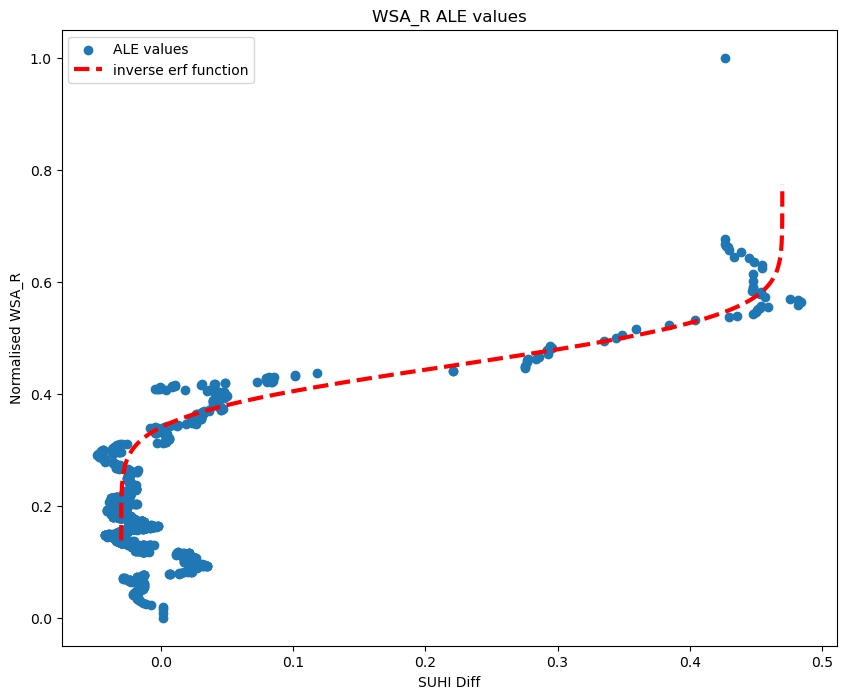

In [922]:
#### Inverse Functions ####
#guess based on fitted function

#Inverse erf function
A, w, p, c = erf_eye[0], erf_eye[1], erf_eye[2], erf_eye[3]

guess = [1/w, 1/A, -c/A, -p/w]
#def inverfunc(t, A_ierf, w_ierf, p_ierf, c_ierf): return A_ierf*inverf(w_ierf*t + p_ierf) + c_ierf

popt, pcov = curve_fit(erfinvfunc, ALE_vals, feature_vals, p0=guess, maxfev=5000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = ALE_vals.min() 
x_max = ALE_vals.max() 

x_vals = np.linspace(x_min, x_max, 90000)
y_vals = erfinvfunc(x_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'inverse erf function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

#arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'A_arc'] = A
#arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'w_arc'] = w
#arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'p_arc'] = p
#arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'c_arc'] = c

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:129: RuntimeWarning: divide by zero encountered in divide
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))
C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:129: RuntimeWarning: divide by zero encountered in log
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))


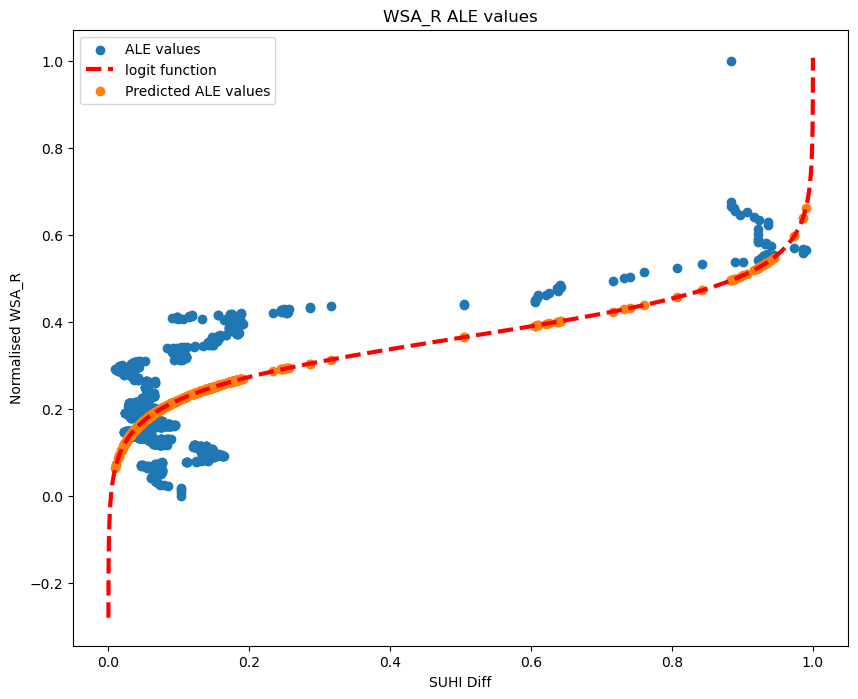

In [923]:
#### Inverse Functions: LOGIT ####

logit_scaler = MinMaxScaler(feature_range = (0.01, 0.99))
ALE_vals_logit_scaled = logit_scaler.fit_transform(ALE_vals.reshape(-1, 1)).reshape(1, -1)[0]

guess = [np.float64(0.035), np.float64(0.5)]

popt, pcov = curve_fit(complogitfunc, ALE_vals_logit_scaled, feature_vals, p0=guess, maxfev=10000)
A,b = popt[0], popt[1]

#generated function values for plotting
x_min = 0
x_max = 1
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = complogitfunc(x_vals, A,b)
feature_vals_pred = complogitfunc(ALE_vals_logit_scaled, A,b)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals_logit_scaled, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'logit function', color = 'red', linewidth=3, linestyle = '--')
axes.scatter(ALE_vals_logit_scaled, feature_vals_pred, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'A'] = A
logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'b'] = b

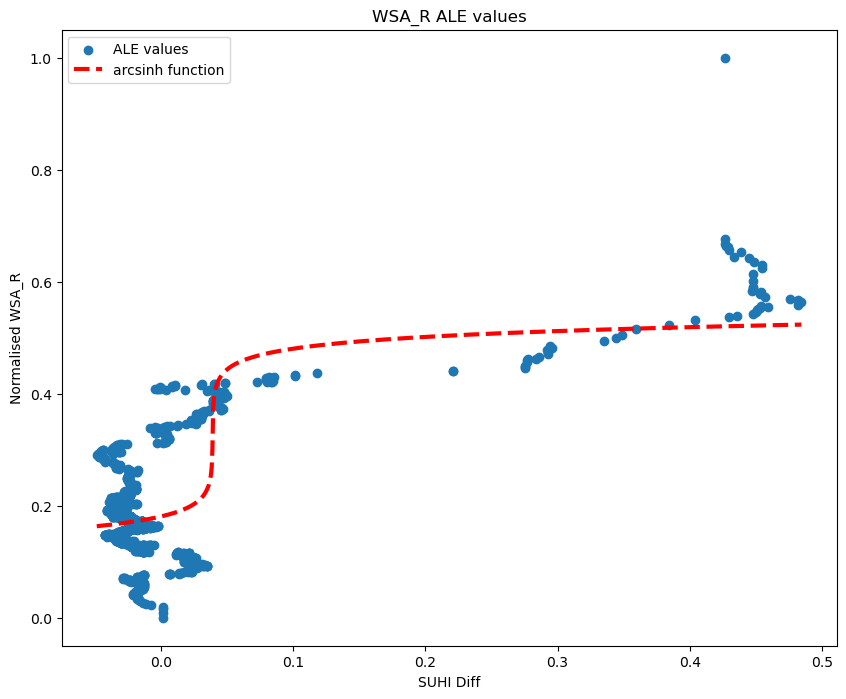

In [924]:
### sinh ###

def arcsinhfunc(t, A, w, p, c):  return A * np.arcsinh(w*t + p) + c

guess = [1, 0.01, 0.05, 2]

popt, pcov = curve_fit(arcsinhfunc, ALE_vals, feature_vals, p0=guess, maxfev=5000)
A, w, p, c= popt[0], popt[1], popt[2], popt[3]

# use weighted values
#feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 25, 
#                                   weighting_low = 25, low_thresh = -1, high_thresh =2 )

#generated function values for plotting
x_min = ALE_vals.min()
x_max = ALE_vals.max()

x_vals = np.linspace(x_min, x_max, 1000)
y_vals = arcsinhfunc(x_vals, A, w, p, c)

# plot the features and function           
fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'arcsinh function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()


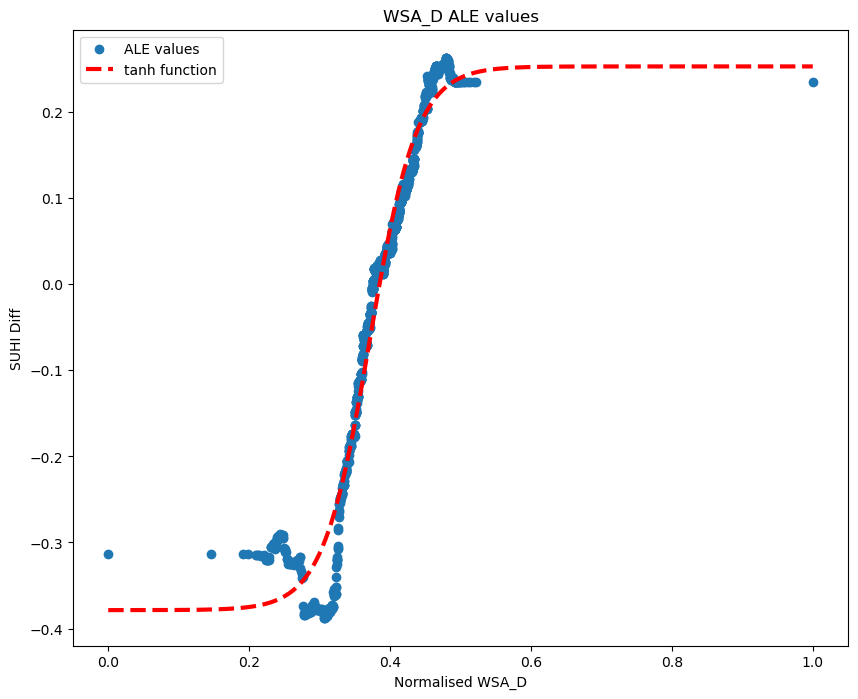

In [961]:
###############
#### WSA_D ####
###############
Feature_Name = 'WSA_D'
ALE_vals = WSA_D_ALE_vals[:,0]
feature_vals = WSA_D_feature_vals

# use weighted values
#feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 8, 
#                                   weighting_low = 8, low_thresh = -1.5, high_thresh =2.5 )

#fit the tanh function
res = fit_tanh(feature_vals, ALE_vals)
A,w,p,c = res['A'], res['w'], res['p'], res['c']

#generated function values for plotting
x_min = math.floor(feature_vals.min())
x_max = math.ceil(feature_vals.max())

x_min = feature_vals.min()
x_max = feature_vals.max()

x_vals = np.linspace(x_min, x_max, 1000)
y_vals = tanhfunc(x_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'tanh function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'A'] = A
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'w'] = w
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'p'] = p
tanh_parameters.loc[tanh_parameters.Feature_Name == Feature_Name,'c'] = c

C:\Users\UEA_Laptop\.conda\envs\suhienv_alibi\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


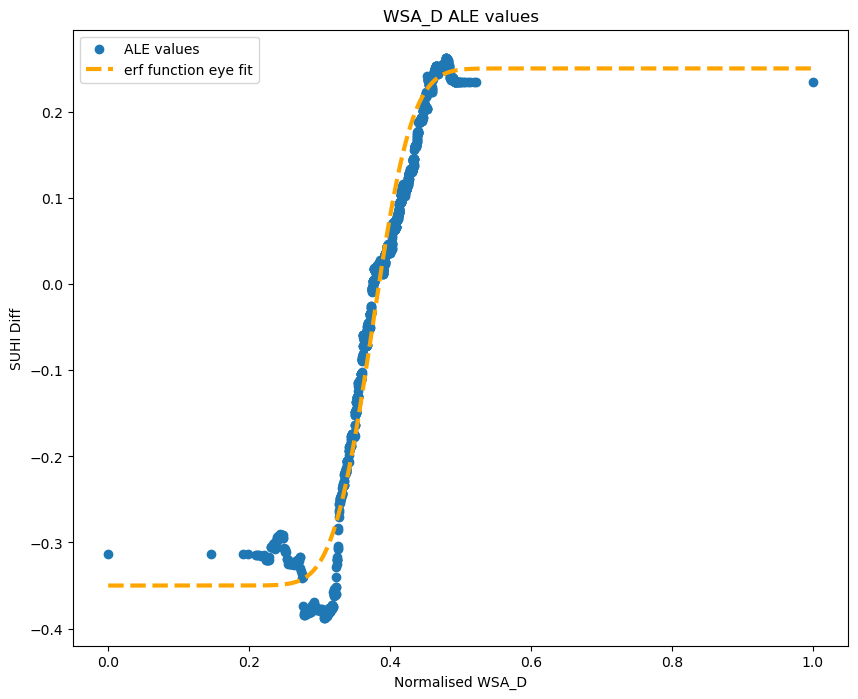

In [926]:
### erf function ###
Feature_Name = 'WSA_D'
ALE_vals = WSA_D_ALE_vals[:,0]
feature_vals = WSA_D_feature_vals

# use weighted values
feature_vals, ALE_vals = weightingfunc(ALE_vals, feature_vals, weighting_high = 25, 
                                   weighting_low = 25, low_thresh = -1, high_thresh =2 )

# max and mins for plotting and guesses
x_min = feature_vals.min()
x_max = feature_vals.max()

y_min = ALE_vals.min()
y_max = ALE_vals.max()

#fit the erf function
guess = [(abs(y_max) + abs(y_min))/2,  1.5,-3.4 ,(y_max +y_min)/2]
popt, pcov = curve_fit(erfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]
# A is amplitude, w controls width/ gradient of curve, p is shift along x axis, c is midpoint

#generated function values for plotting
x_vals = np.linspace(x_min, x_max, 1000)
y_vals = erfunc(x_vals, A,w,p,c)

erf_eye = [0.3,16,-6,-0.05]
y_vals2 = erfunc(x_vals,erf_eye[0],erf_eye[1],erf_eye[2],erf_eye[3])

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(feature_vals, ALE_vals, label = 'ALE values')
#axes.plot(x_vals, y_vals, label = 'erf function', color = 'red', linewidth=3, linestyle = '--')
axes.plot(x_vals, y_vals2, label = 'erf function eye fit', color = 'orange', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         xlabel = 'Normalised {}'.format(Feature_Name), ylabel = 'SUHI Diff')
axes.legend()

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:104: RuntimeWarning: invalid value encountered in arctanh
  def arctanhfunc(t, A_arc, w_arc, p_arc, c_arc):  return A_arc * np.arctanh(w_arc*t + p_arc) + c_arc


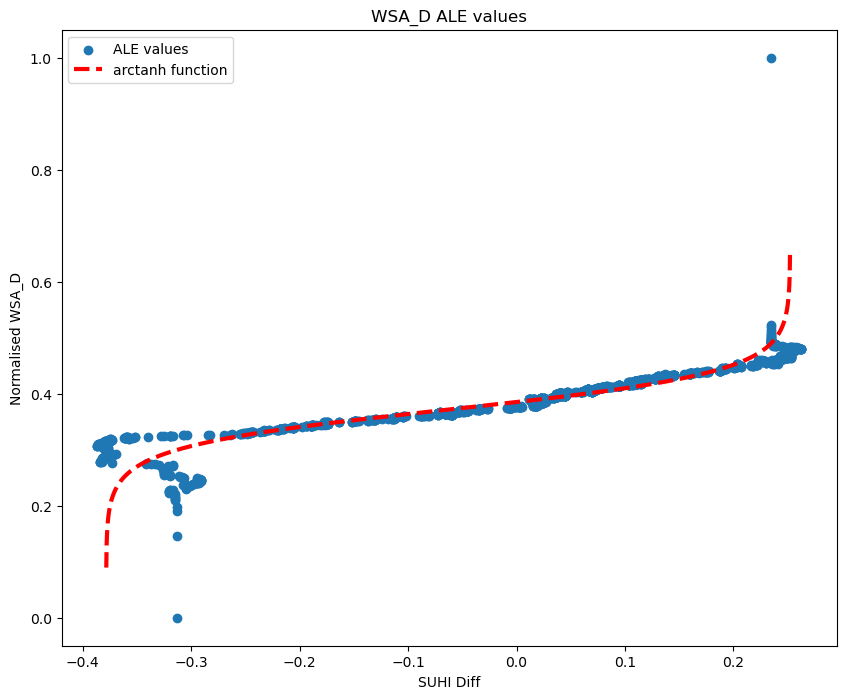

In [927]:
#### Inverse Functions ####
#guess based on fitted function

A,w,p,c = (tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].A.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].w.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].p.values[0],
tanh_parameters[tanh_parameters.Feature_Name == Feature_Name].c.values[0])

guess = [1/w, 1/A, -c/A, -p/w]

popt, pcov = curve_fit(arctanhfunc, ALE_vals, feature_vals, p0=guess, maxfev=5000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = ALE_vals.min()
x_max = ALE_vals.max()

x_vals = np.linspace(x_min, x_max, 2000)
y_vals = arctanhfunc(x_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'arctanh function', color = 'red', linewidth=3, linestyle = '--')
axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

# add the fit parameters to the dataframe

arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'A_arc'] = A
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'w_arc'] = w
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'p_arc'] = p
arctanh_parameters.loc[arctanh_parameters.Feature_Name == Feature_Name,'c_arc'] = c

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:129: RuntimeWarning: divide by zero encountered in divide
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))
C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_6476\1740631441.py:129: RuntimeWarning: divide by zero encountered in log
  def complogitfunc(t, A, b): return b - A*np.log(t / (1-t))


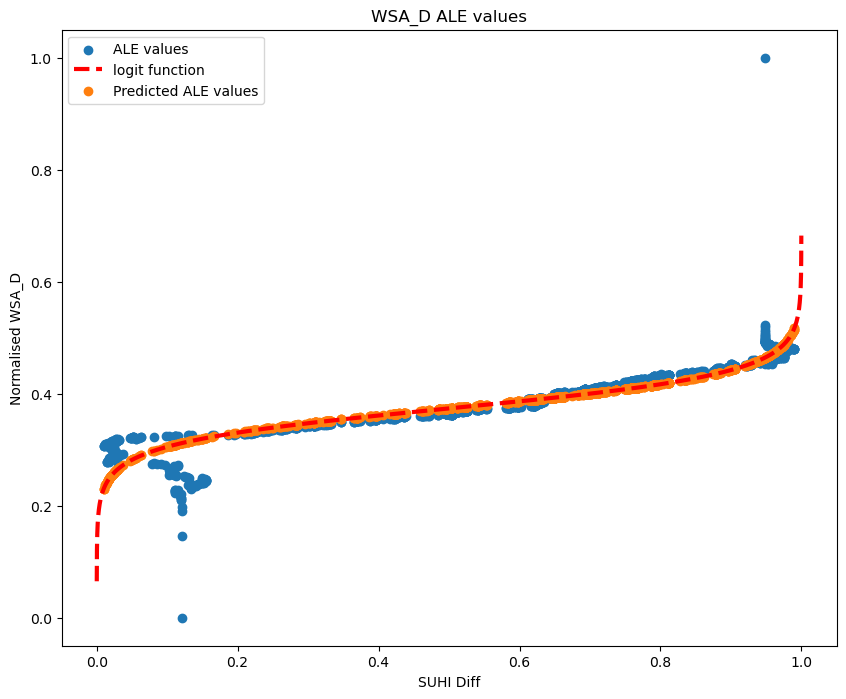

In [928]:
#### Inverse Functions: LOGIT ####

logit_scaler = MinMaxScaler(feature_range = (0.01, 0.99))
ALE_vals_logit_scaled = logit_scaler.fit_transform(ALE_vals.reshape(-1, 1)).reshape(1, -1)[0]

guess = [np.float64(0.035), np.float64(0.5)]

popt, pcov = curve_fit(complogitfunc, ALE_vals_logit_scaled, feature_vals, p0=guess, maxfev=10000)
A,b = popt[0], popt[1]

#generated function values for plotting
x_min = 0
x_max = 1
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = complogitfunc(x_vals, A,b)
feature_vals_pred = complogitfunc(ALE_vals_logit_scaled, A,b)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals_logit_scaled, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'logit function', color = 'red', linewidth=3, linestyle = '--')
axes.scatter(ALE_vals_logit_scaled, feature_vals_pred, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'A'] = A
logit_parameters.loc[logit_parameters.Feature_Name == Feature_Name,'b'] = b

C:\Users\UEA_Laptop\.conda\envs\suhienv_alibi\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


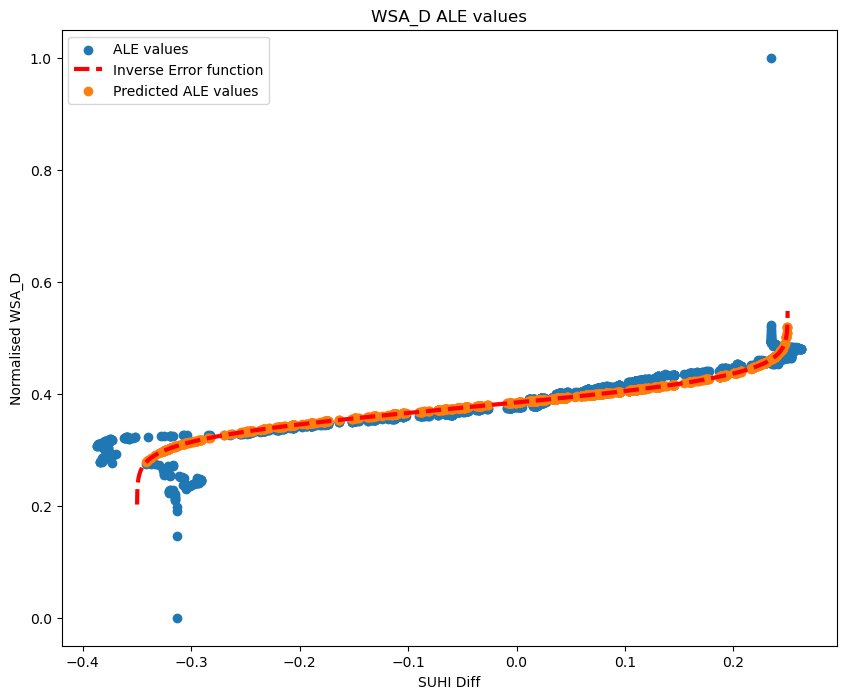

In [929]:
## inverse erf function

A,w,p,c = 0.3,16,-6,-0.05
guess = [1/w, 1/A, -c/A, -p/w]
popt, pcov = curve_fit(erfinvfunc, ALE_vals, feature_vals, p0=guess, maxfev=10000)
A,w,p,c = popt[0], popt[1], popt[2], popt[3]

#generated function values for plotting
x_min = ALE_vals.min()
x_max = ALE_vals.max()
x_vals = np.linspace(x_min, x_max, 20000)
y_vals = erfinvfunc(x_vals, A,w,p,c)
feature_vals_pred = erfinvfunc(ALE_vals, A,w,p,c)

fig, axes = plt.subplots(1,1, figsize = (10, 8))

# plot the features and function
axes.scatter(ALE_vals, feature_vals, label = 'ALE values')
axes.plot(x_vals, y_vals, label = 'Inverse Error function', color = 'red', linewidth=3, linestyle = '--')
axes.scatter(ALE_vals, feature_vals_pred, label = 'Predicted ALE values')
#axes.plot(x_vals, y_vals2, label = 'sinh function eye fit', color = 'orange', linewidth=3)

axes.set(title = '{} ALE values'.format(Feature_Name), 
         ylabel = 'Normalised {}'.format(Feature_Name), xlabel = 'SUHI Diff')
axes.legend()

erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'A'] = A
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'w'] = w
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'p'] = p
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'c'] = c
erfinv_parameters.loc[erfinv_parameters.Feature_Name == Feature_Name,'Function'] = 'erfinv'

In [513]:
arctanh_parameters

,Feature_Name,A_arc,w_arc,p_arc,c_arc
0,SSR_NO_SEASON,-0.065931,7.261072,-0.440155,0.475625
1,EVI_R,7.198556,0.001262,0.957246,-13.385269
2,EVI_D,-0.370992,0.443208,-0.045025,0.689798
3,WSA_R,0.058645,4.225487,-0.920355,0.455994
4,WSA_D,0.066651,3.170183,0.200014,0.371606


In [404]:
arctanh_parameters

,Feature_Name,A_arc,w_arc,p_arc,c_arc
0,SSR_NO_SEASON,-0.490691,6.971106,-0.502102,-0.594069
1,EVI_R,2.119384,0.229662,0.057183,-0.164827
2,EVI_D,-11.443646,0.000332,0.998504,41.344553
3,WSA_R,0.344075,4.236868,-0.925486,2.325924
4,WSA_D,1.230574,3.879372,0.143654,-0.201461


In [719]:
logit_parameters

,Feature_Name,A,b
0,SSR_NO_SEASON,0.045235,0.472514
1,EVI_R,-0.124998,0.443498
2,EVI_D,0.130495,0.617798
3,WSA_R,-0.064963,0.363576
4,WSA_D,-0.031165,0.373729


In [930]:
erfinv_parameters

,Feature_Name,Function,A,w,p,c
0,SSR_NO_SEASON,cerfinv,0.105263,7.407407,0.548148,0.473684
1,EVI_R,erfinv,0.25,0.3125,-0.125,0.45
2,EVI_D,cerfinv,0.2,0.666667,0.933333,0.7
3,WSA_R,erfinv,0.1,4.0,-0.88,0.45
4,WSA_D,erfinv,0.0625,3.333333,0.166667,0.375


In [720]:
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
     
with open('logit_parameters.pkl', 'wb') as f:
     pickle.dump(logit_parameters, f)   

In [962]:
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
     
with open('arctanh_parameters.pkl', 'wb') as f:
     pickle.dump(arctanh_parameters, f)     
     
    
with open('tanh_parameters.pkl', 'wb') as f:
     pickle.dump(tanh_parameters, f)   


In [931]:
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
     
with open('erfinv_parameters.pkl', 'wb') as f:
     pickle.dump(erfinv_parameters, f)   

In [1132]:
def func(x, a,b,c,d,e): return (a/(1+b*np.exp(-c*x))) + d*x +e

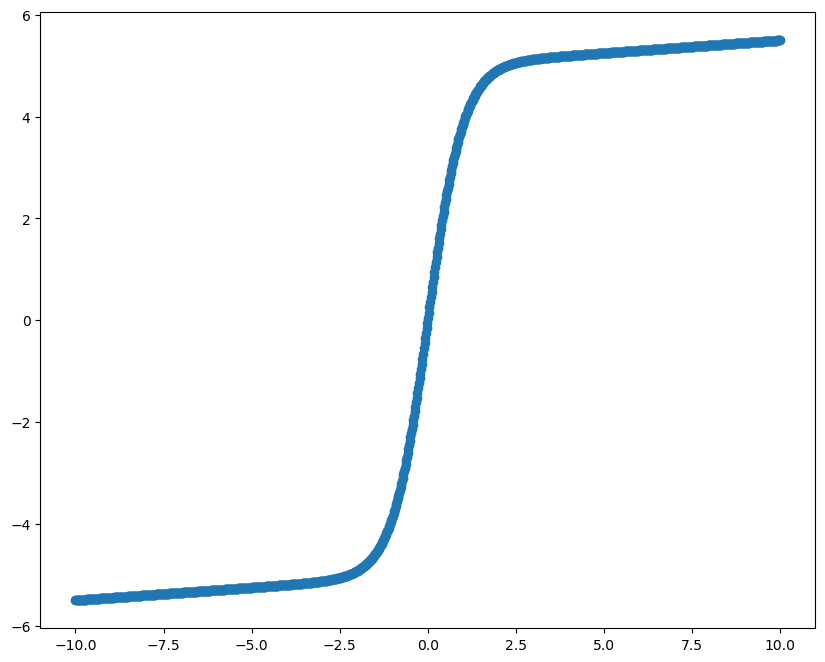

In [1133]:
fig, axes = plt.subplots(1,1, figsize = (10, 8))

a,b,c,d,e = 10, 1,2,1/20,-5

#guess = [1/w, 1/A, -c/A, -p/w]
#popt, pcov = curve_fit(func, ALE_vals, feature_vals, p0=guess, maxfev=10000)
#a,b,c,d,e = popt[0], popt[1], popt[2], popt[3], popt[4]

x_vals = np.linspace(-10,10, 1000)
y_vals = func(x_vals, a,b,c,d,e)


# plot the features and function
axes.scatter(x_vals, y_vals)

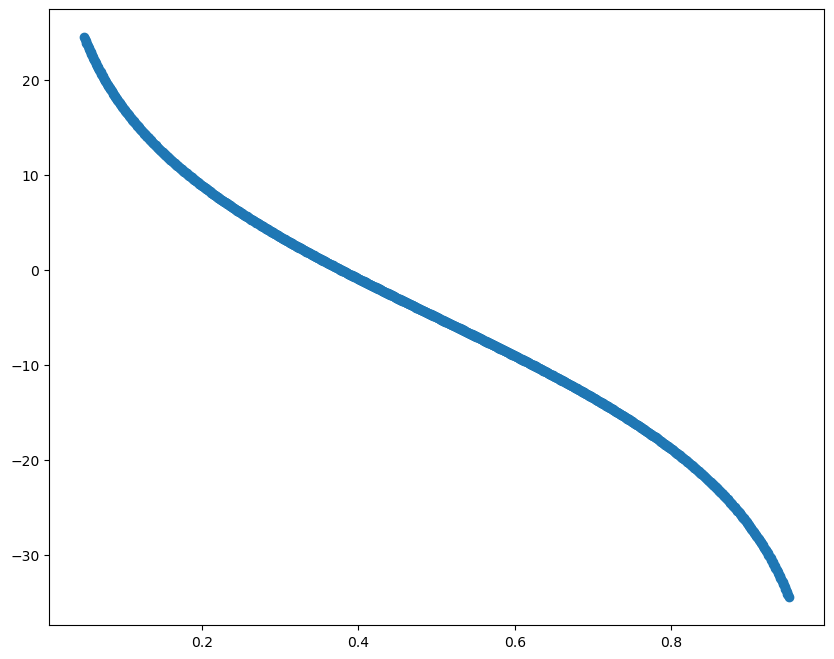

In [1152]:
def func(x, a,b,c,d,e): return (a*np.log(b*x/(1-x))) + d*x +e

fig, axes = plt.subplots(1,1, figsize = (10, 8))

a,b,c,d,e = -10, 1,2,1/10000,-5

#guess = [1/w, 1/A, -c/A, -p/w]
#popt, pcov = curve_fit(func, ALE_vals, feature_vals, p0=guess, maxfev=10000)
#a,b,c,d,e = popt[0], popt[1], popt[2], popt[3], popt[4]

x_vals = np.linspace(0.05,0.95, 1000)
y_vals = func(x_vals, a,b,c,d,e)


# plot the features and function
axes.scatter(x_vals, y_vals)